In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

Load the text extraction data (assuming multiple cluster files) and the video engagement data.

In [2]:
# Specify the folder containing the cluster files
cluster_folder = 'text_clusters'  # Replace with the actual folder path

# List all CSV files in the folder
cluster_files = [os.path.join(cluster_folder, f) for f in os.listdir(cluster_folder) if f.endswith('.csv')]

# Print the list of files to verify
print("cluster Files Found:")
print(cluster_files)

cluster Files Found:
['text_clusters\\df_cluster_0.csv', 'text_clusters\\df_cluster_1.csv', 'text_clusters\\df_cluster_2.csv', 'text_clusters\\df_cluster_3.csv', 'text_clusters\\df_cluster_4.csv']


In [3]:
# Combine all cluster data into one DataFrame
text_data = pd.concat([pd.read_csv(file) for file in cluster_files], ignore_index=True)

# Load video engagement data
video_data = pd.read_csv('Final_clustering/Results_Count_Final.csv')

In [4]:
# Display the first few rows of both datasets
print("\nText Extraction Data:")
print(text_data.head())
print("\nNumber of rows and columns in text_data:", text_data.shape)

print("\nVideo Engagement Data:")
print(video_data.head())
print("\nNumber of rows and columns in video_data:", video_data.shape)


Text Extraction Data:
      Video ID text_cleaned  cluster  x0_Bert-CLS  x1_Bert-CLS
0  CUhaitHEAZE          NaN        0    -6.414154    -1.595282
1  MovIpxxyOlo          NaN        0    -6.414154    -1.595282
2  vrwkd3W1lD0          NaN        0    -6.414154    -1.595282
3  6TiMvS0rE2I          NaN        0    -6.414154    -1.595282
4  BUCANbJ9rZs          NaN        0    -6.414154    -1.595282

Number of rows and columns in text_data: (2587, 5)

Video Engagement Data:
       VideoID  View Count  Like Count  Comment Count
0  --8n6A8Q6M0      338385       11044           1371
1  -0FfyNZdHk0         147           4              1
2  -1B7cVoZr1c      150876        3011            225
3  -4yu_13EHFM       28277        1158            381
4  -6FvAU9H98w       63409        1277            110

Number of rows and columns in video_data: (3715, 4)


In [5]:
# Merge datasets on VideoID, renaming 'Video ID' in text_data to match 'VideoID' in video_data
# First rename the column in text_data
text_data = text_data.rename(columns={'Video ID': 'VideoID'})

# Now merge using the consistent column name
merged_data = pd.merge(text_data, video_data, on='VideoID', how='inner')

# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID text_cleaned  cluster  x0_Bert-CLS  x1_Bert-CLS  View Count  \
0  CUhaitHEAZE          NaN        0    -6.414154    -1.595282       45402   
1  MovIpxxyOlo          NaN        0    -6.414154    -1.595282     5532347   
2  vrwkd3W1lD0          NaN        0    -6.414154    -1.595282      691411   
3  6TiMvS0rE2I          NaN        0    -6.414154    -1.595282      134338   
4  BUCANbJ9rZs          NaN        0    -6.414154    -1.595282      588360   

   Like Count  Comment Count  
0        1889            262  
1       83043           6984  
2       31855           2486  
3           0            328  
4       11737            883  

Number of rows and columns: (2568, 8)


In [6]:
# Merge datasets on 'Video ID'
merged_data = pd.merge(text_data, video_data, on='VideoID', how='inner')

# Read the results_final.csv file
results_df = pd.read_csv('results_final.csv')

# Rename the 'Video Id' column to 'VideoID' in results_df to match merged_data
results_df = results_df.rename(columns={'Video Id': 'VideoID'})

# Merge the Channel Title from results_df into merged_data
merged_data = pd.merge(merged_data, results_df[['VideoID', 'Channel Title']], on='VideoID', how='inner')


# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID text_cleaned  cluster  x0_Bert-CLS  x1_Bert-CLS  View Count  \
0  CUhaitHEAZE          NaN        0    -6.414154    -1.595282       45402   
1  MovIpxxyOlo          NaN        0    -6.414154    -1.595282     5532347   
2  vrwkd3W1lD0          NaN        0    -6.414154    -1.595282      691411   
3  6TiMvS0rE2I          NaN        0    -6.414154    -1.595282      134338   
4  BUCANbJ9rZs          NaN        0    -6.414154    -1.595282      588360   

   Like Count  Comment Count               Channel Title  
0        1889            262               The Commodity  
1       83043           6984  Best Ever Food Review Show  
2       31855           2486                Pinoy Planet  
3           0            328                Mia Sandoval  
4       11737            883             HellthyJunkFood  

Number of rows and columns: (2568, 9)


Check the number of channels per cluster, to see the difference on each channel

In [8]:
# Group by Cluster and Channel Title, then count videos
cluster_channel_counts = merged_data.groupby(['cluster', 'Channel Title']).size().reset_index(name='Video Count')

# Sort by cluster and Video Count in descending order
cluster_channel_counts = cluster_channel_counts.sort_values(['cluster', 'Video Count'], ascending=[True, False])

# Create a list to store the top 10 channels per cluster
top_channels = []

# Get top 10 channels for each cluster
for cluster in sorted(cluster_channel_counts['cluster'].unique()):
    # Get top 10 channels for this cluster
    cluster_data = cluster_channel_counts[cluster_channel_counts['cluster'] == cluster].nlargest(10, 'Video Count')
    
    # Add cluster header
    top_channels.append({
        'cluster': f"cluster {cluster}",
        'Channel': '---',
        'Video Count': '---'
    })
    
    # Add top 10 channels
    for _, row in cluster_data.iterrows():
        top_channels.append({
            'cluster': '',
            'Channel': row['Channel Title'],
            'Video Count': row['Video Count']
        })

# Create DataFrame from formatted results
result_df = pd.DataFrame(top_channels)

# Save to CSV
result_df.to_csv('Final_clustering/Text/top_channels_per_cluster.csv', index=False)

# Print the results
print("\nTop 10 channels per cluster:")
for cluster in sorted(cluster_channel_counts['cluster'].unique()):
    cluster_data = cluster_channel_counts[cluster_channel_counts['cluster'] == cluster].nlargest(10, 'Video Count')
    print(f"\ncluster {cluster}:")
    for _, row in cluster_data.iterrows():
        print(f"Channel: {row['Channel Title']} - Videos: {row['Video Count']}")


Top 10 channels per cluster:

cluster 0:
Channel: Ken Abroad - Videos: 13
Channel: Pinoy Planet - Videos: 12
Channel: Beryl Shereshewsky - Videos: 7
Channel: BuzzFeedVideo - Videos: 7
Channel: Xiaomanyc 小马在纽约 - Videos: 7
Channel: JREKML - Videos: 6
Channel: Mark Wiens - Videos: 6
Channel: NOW UNITED - Videos: 6
Channel: The Commodity - Videos: 6
Channel: Travel with Luke Damant - Videos: 6

cluster 1:
Channel: Pinoy Planet - Videos: 33
Channel: Waleska Herrera - Videos: 32
Channel: Adam and Jane's Lifestyle - Videos: 30
Channel: Music Game News - Videos: 25
Channel: JUICY REACTS - Videos: 20
Channel: Mia Sandoval - Videos: 13
Channel: The Commodity - Videos: 11
Channel: The Juicy Vlog - Videos: 10
Channel: Always Be Changing - Videos: 8
Channel: Dodo Explorers - Videos: 8

cluster 2:
Channel: Waleska Herrera - Videos: 85
Channel: The Garcia Family - Videos: 26
Channel: TriFate Geo - Videos: 20
Channel: Pinoy Planet - Videos: 18
Channel: The Love Train Nation - Videos: 18
Channel: The 

Check what is the top 5 channel with the most video with each cluster

C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\2312477246.py:23: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\2312477246.py:23: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\2312477246.py:23: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\2312477246.py:23: UserWarning: Glyph 32445 (\N{CJK UNIFIED IDEOGRAPH-7EBD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\2312477246.py:23: UserWarning: Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

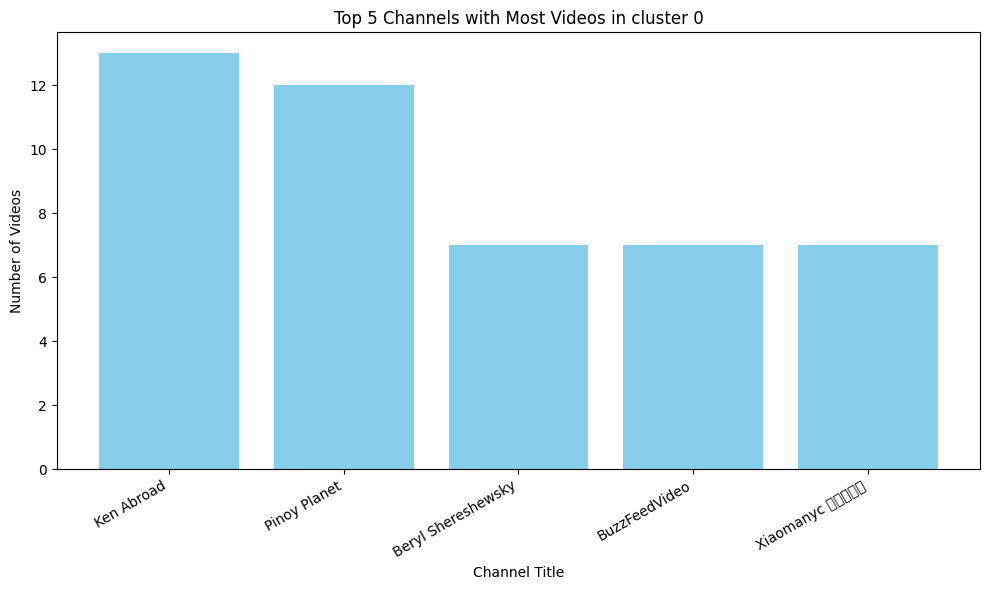

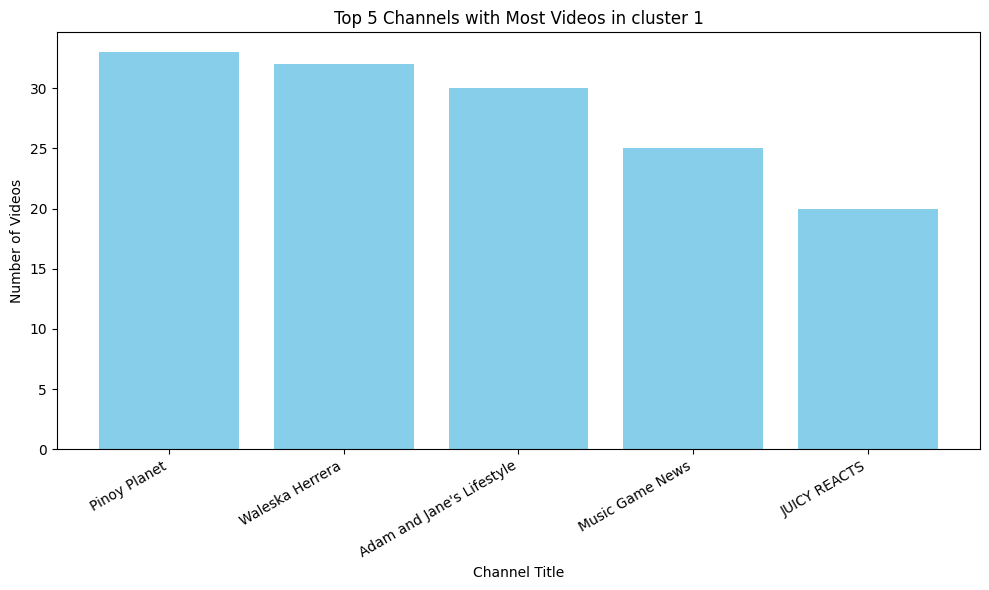

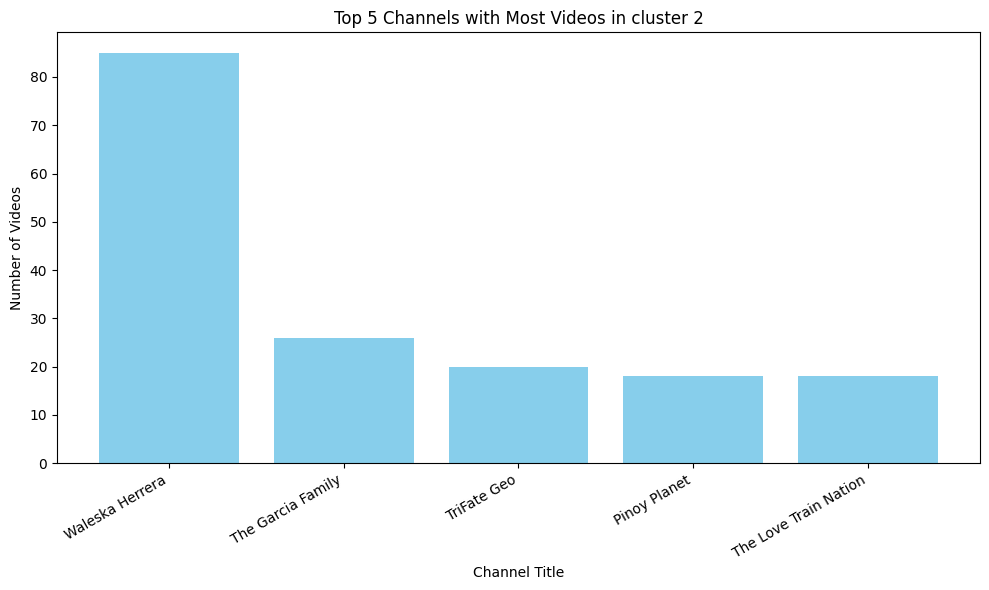

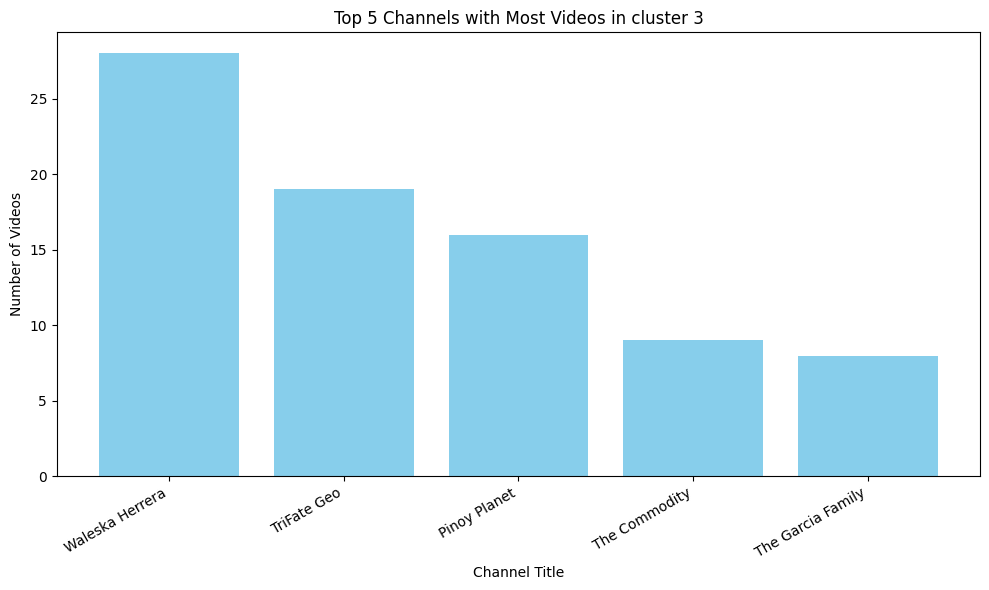

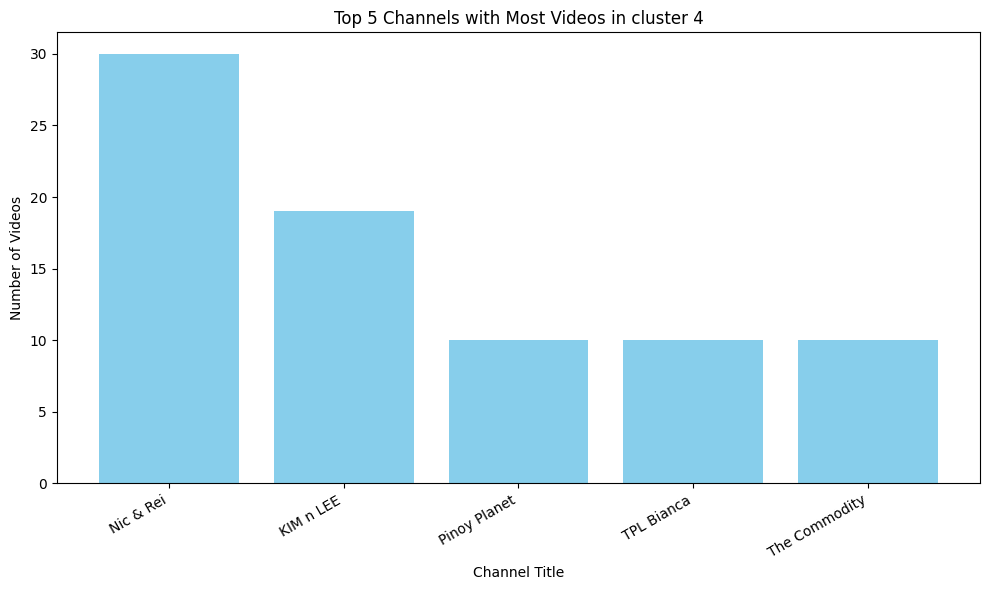

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by cluster and Channel Title, then count videos
cluster_channel_counts = merged_data.groupby(['cluster', 'Channel Title']).size().reset_index(name='Video Count')

# Sort by cluster and Video Count in descending order
cluster_channel_counts = cluster_channel_counts.sort_values(['cluster', 'Video Count'], ascending=[True, False])

# Plotting
clusters = sorted(cluster_channel_counts['cluster'].unique())
for cluster in clusters:
    cluster_data = cluster_channel_counts[cluster_channel_counts['cluster'] == cluster]
    # Get top 5 channels for this cluster
    top5 = cluster_data.nlargest(5, 'Video Count')[['Channel Title', 'Video Count']]
    
    plt.figure(figsize=(10, 6))
    plt.bar(top5['Channel Title'], top5['Video Count'], color='skyblue')
    plt.title(f'Top 5 Channels with Most Videos in cluster {cluster}')
    plt.xlabel('Channel Title')
    plt.ylabel('Number of Videos')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\3325063678.py:68: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\3325063678.py:68: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\3325063678.py:68: UserWarning: Glyph 22312 (\N{CJK UNIFIED IDEOGRAPH-5728}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\3325063678.py:68: UserWarning: Glyph 32445 (\N{CJK UNIFIED IDEOGRAPH-7EBD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Temp\ipykernel_59988\3325063678.py:68: UserWarning: Glyph 32422 (\N{CJK UNIFIED IDEOGRAPH-7EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yesha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalC

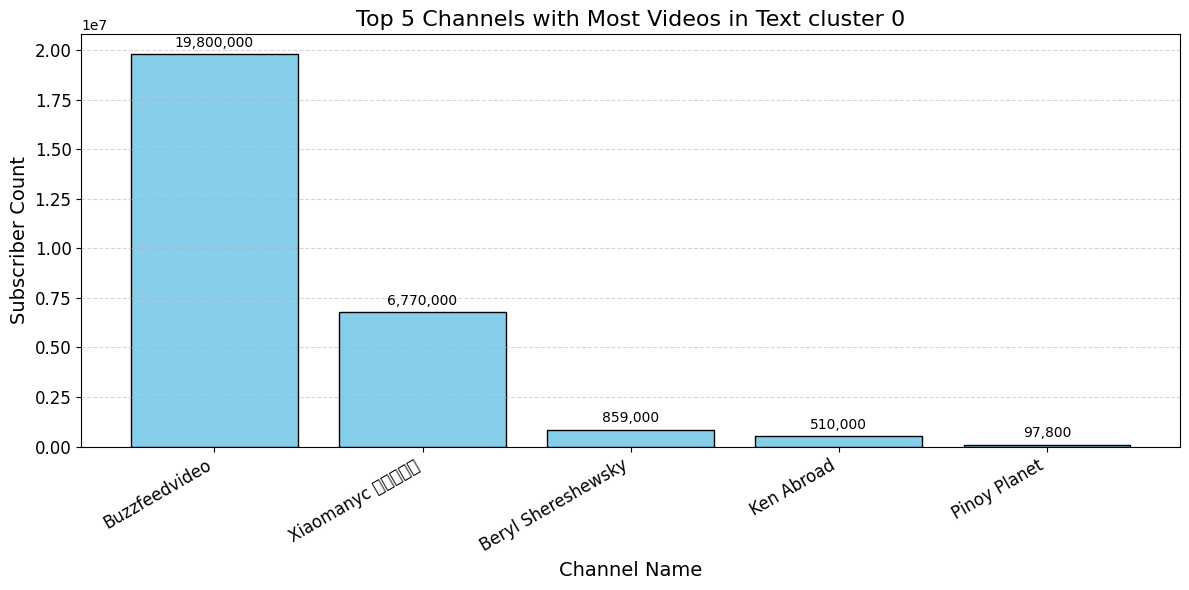

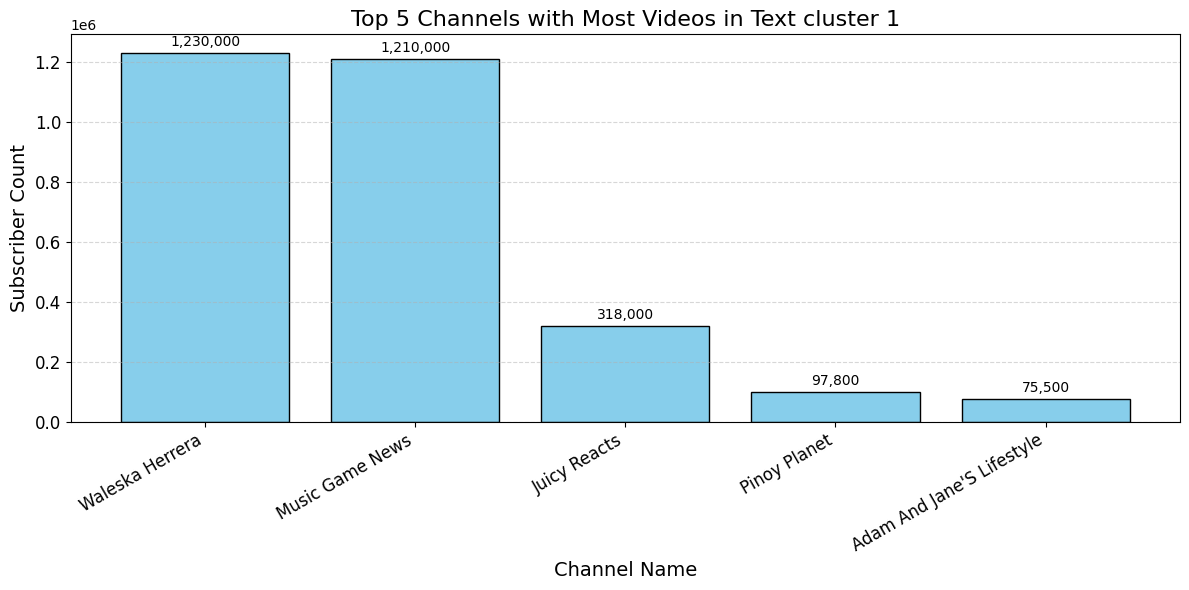

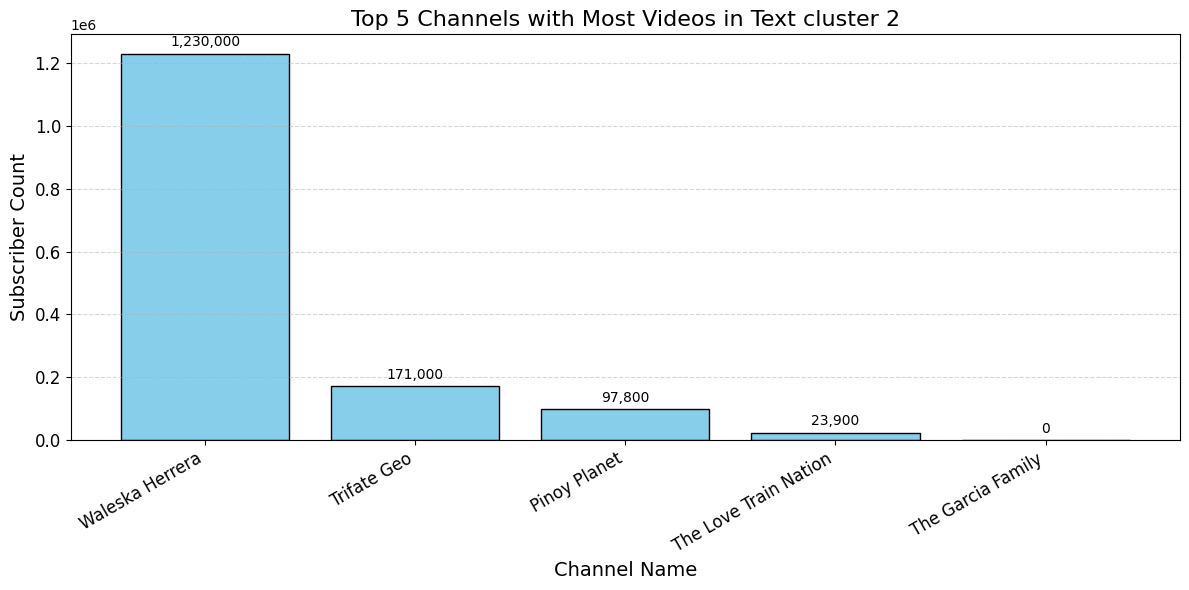

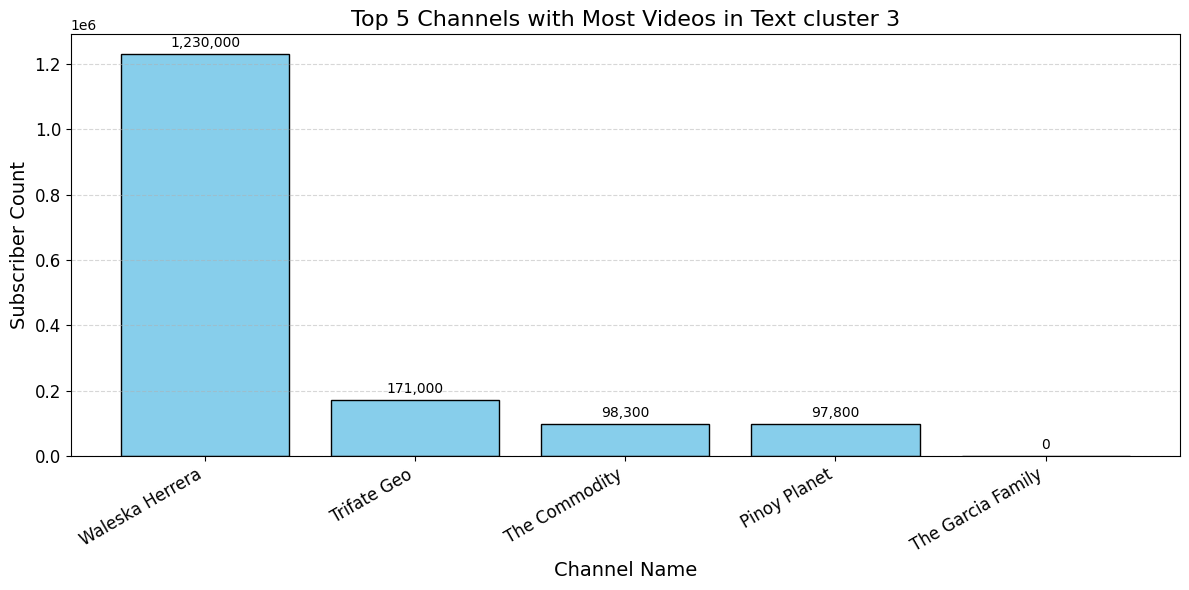

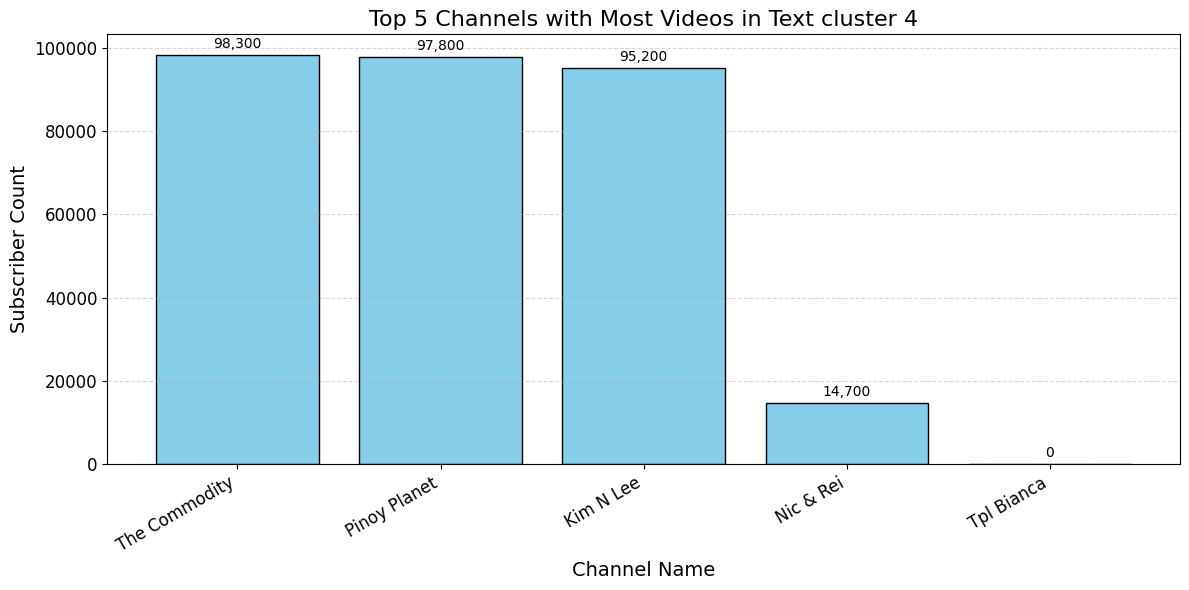


Summary of Top 5 Channels per Text cluster:

Text cluster 0:
Number of channels: 5
Average subscriber count: 5,607,360
Total subscriber count: 28,036,800
Top channels:
  - Ken Abroad: 13 videos, 510,000 subscribers
  - Pinoy Planet: 12 videos, 97,800 subscribers
  - Beryl Shereshewsky: 7 videos, 859,000 subscribers

Text cluster 1:
Number of channels: 5
Average subscriber count: 586,260
Total subscriber count: 2,931,300
Top channels:
  - Pinoy Planet: 33 videos, 97,800 subscribers
  - Waleska Herrera: 32 videos, 1,230,000 subscribers
  - Adam And Jane'S Lifestyle: 30 videos, 75,500 subscribers

Text cluster 2:
Number of channels: 5
Average subscriber count: 304,540
Total subscriber count: 1,522,700
Top channels:
  - Waleska Herrera: 85 videos, 1,230,000 subscribers
  - The Garcia Family: 26 videos, 0 subscribers
  - Trifate Geo: 20 videos, 171,000 subscribers

Text cluster 3:
Number of channels: 5
Average subscriber count: 319,420
Total subscriber count: 1,597,100
Top channels:
  - Wa

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Parse the top channels CSV
rows = []
current_cluster = None

with open("Final_clustering/Text/top_channels_per_cluster.csv", encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line.startswith("cluster"):
            match = re.search(r'cluster\s+(\d+)', line)
            if match:
                current_cluster = match.group(1)
        elif line.startswith(',') and ',' in line:
            parts = line.split(',')
            if len(parts) >= 3 and current_cluster is not None:
                channel = parts[1].strip()
                try:
                    video_count = int(parts[2])
                except ValueError:
                    video_count = None
                rows.append({
                    'cluster': current_cluster,
                    'Channel Name': channel,
                    'Video Count': video_count
                })

top_channels_df = pd.DataFrame(rows)

# 2. Load subscriber data
subs = pd.read_csv("Final_clustering/Final_Suscribers_Count.csv")

# 3. Clean and standardize channel names for merging
top_channels_df['Channel Name'] = top_channels_df['Channel Name'].str.strip().str.lower()
subs['Channel Name'] = subs['Channel Name'].str.strip().str.lower()

# 4. Merge on 'Channel Name'
merged = top_channels_df.merge(subs[['Channel Name', 'Subscriber Count']], on='Channel Name', how='left')

# 5. For each cluster, select the top 5 channels by Video Count
top5_per_cluster = (
    merged.sort_values(['cluster', 'Video Count'], ascending=[True, False])
    .groupby('cluster')
    .head(5)
)

# 6. Fill missing subscriber counts with 0 for plotting
top5_per_cluster['Subscriber Count'] = top5_per_cluster['Subscriber Count'].fillna(0)

# 7. Plotting: one figure per cluster, only top 5 channels
clusters = sorted(top5_per_cluster['cluster'].unique(), key=lambda x: int(x))

for cluster in clusters:
    data = top5_per_cluster[top5_per_cluster['cluster'] == cluster].sort_values('Subscriber Count', ascending=False)
    
    if len(data) > 0:  # Only plot if there's data for this cluster
        plt.figure(figsize=(12, 6))
        bars = plt.bar(data['Channel Name'].str.title(), data['Subscriber Count'], color='skyblue', edgecolor='black')
        plt.title(f"Top 5 Channels with Most Videos in Text cluster {cluster}", fontsize=16)
        plt.xlabel("Channel Name", fontsize=14)
        plt.ylabel("Subscriber Count", fontsize=14)
        plt.xticks(rotation=30, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{int(height):,}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
        plt.show()

# 8. Print summary statistics
print("\nSummary of Top 5 Channels per Text cluster:")
print("=" * 50)
for cluster in clusters:
    data = top5_per_cluster[top5_per_cluster['cluster'] == cluster]
    print(f"\nText cluster {cluster}:")
    print(f"Number of channels: {len(data)}")
    if len(data) > 0:
        print(f"Average subscriber count: {data['Subscriber Count'].mean():,.0f}")
        print(f"Total subscriber count: {data['Subscriber Count'].sum():,.0f}")
        print("Top channels:")
        for _, row in data.head(3).iterrows():
            print(f"  - {row['Channel Name'].title()}: {row['Video Count']} videos, {row['Subscriber Count']:,.0f} subscribers")

In [13]:
# Calculate and print total subscriber count for top 5 channels in each cluster
print("Total Subscriber Count")
for cluster in sorted(top5_per_cluster['cluster'].unique(), key=lambda x: int(x)):
    data = top5_per_cluster[top5_per_cluster['cluster'] == cluster]
    total = int(data['Subscriber Count'].sum())
    print(f"Cluster {cluster}: {total:,}")

Total Subscriber Count
Cluster 0: 28,036,800
Cluster 1: 2,931,300
Cluster 2: 1,522,700
Cluster 3: 1,597,100
Cluster 4: 306,000


## ANOVA Correlation(With Weight)

In [ ]:
print(merged_data)

          VideoID                    text_cleaned  cluster  x0_Bert-CLS  \
0     CUhaitHEAZE                             NaN        0    -6.414154   
1     MovIpxxyOlo                             NaN        0    -6.414154   
2     vrwkd3W1lD0                             NaN        0    -6.414154   
3     6TiMvS0rE2I                             NaN        0    -6.414154   
4     BUCANbJ9rZs                             NaN        0    -6.414154   
...           ...                             ...      ...          ...   
2563  vge15YEaLbk                     philippines        4    -2.677148   
2564  oIB4GxgZ5eY                        PART 135        4    -1.028945   
2565  gYW5By-VDYs  PASTA EXPRESS Creamy Carbonara        4    -1.003235   
2566  VXWFdonv_-Q                        Jollibee        4    -2.827897   
2567  Ev5dUwAQz7M     15 Popular Filipino Snacks!        4    -0.641984   

      x1_Bert-CLS  View Count  Like Count  Comment Count  \
0       -1.595282       45402        18

In [ ]:
# Calculate channel frequencies across the entire dataset
channel_frequencies = merged_data.groupby('Channel Title').size()
total_videos = len(merged_data)

# Calculate weights (inverse of frequency)
# Add 1 to avoid division by zero and smooth the weights
channel_weights = 1 / (channel_frequencies + 1)

# Normalize weights to sum to 1
channel_weights = channel_weights / channel_weights.sum()

# Create a copy of the original data
weighted_data = merged_data.copy()

# Add weights to the dataset
weighted_data['Channel_Weight'] = weighted_data['Channel Title'].map(channel_weights)

# Print some statistics about the weights
print("\nChannel Weight Statistics:")
print("------------------------")
print(f"Number of unique channels: {len(channel_weights)}")
print(f"Minimum weight: {channel_weights.min():.6f}")
print(f"Maximum weight: {channel_weights.max():.6f}")
print(f"Mean weight: {channel_weights.mean():.6f}")

# Show example of weights for some channels
print("\nExample Channel Weights:")
print("----------------------")
example_channels = channel_weights.nlargest(5).index.tolist() + channel_weights.nsmallest(5).index.tolist()
for channel in example_channels:
    print(f"{channel}:")
    print(f"  Frequency: {channel_frequencies[channel]} videos")
    print(f"  Weight: {channel_weights[channel]:.6f}")

# Calculate weighted statistics for numeric columns
numeric_columns = weighted_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['cluster', 'Channel_Weight']]

# Calculate weighted means for each cluster
weighted_cluster_stats = []
for cluster in sorted(weighted_data['cluster'].unique()):
    cluster_data = weighted_data[weighted_data['cluster'] == cluster]
    
    # Calculate weighted statistics
    weighted_stats = {
        'Cluster': cluster,
        'Total_Videos': len(cluster_data),
        'Unique_Channels': len(cluster_data['Channel Title'].unique())
    }
    
    # Calculate weighted means for each numeric column
    for column in numeric_columns:
        weighted_mean = np.average(cluster_data[column], weights=cluster_data['Channel_Weight'])
        weighted_stats[f'Weighted_Mean_{column}'] = weighted_mean
    
    weighted_cluster_stats.append(weighted_stats)

# Convert to DataFrame
weighted_stats_df = pd.DataFrame(weighted_cluster_stats)

# Save the weighted dataset and statistics
weighted_data.to_csv('Final_clustering/Text/Correlational/channel_weighted_data.csv', index=False)
weighted_stats_df.to_csv('Final_clustering/Text/weighted_cluster_statistics.csv', index=False)

# Print weighted cluster statistics
print("\nWeighted Cluster Statistics:")
print("--------------------------")
print(weighted_stats_df)

# Optional: Create a visualization of the weights distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(channel_weights, bins=50)
plt.title('Distribution of Channel Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Channels')
plt.savefig('Final_clustering/Text/Correlational/channel_weights_distribution.png')
plt.close()

# Print summary of the weighted analysis
print("\nSummary of Weighted Analysis:")
print("---------------------------")
print(f"Total videos analyzed: {len(weighted_data)}")
print(f"Total unique channels: {len(channel_weights)}")
print(f"Average videos per channel: {channel_frequencies.mean():.2f}")
print(f"Median videos per channel: {channel_frequencies.median():.2f}")
print(f"Maximum videos per channel: {channel_frequencies.max()}")
print(f"Minimum videos per channel: {channel_frequencies.min()}")


Channel Weight Statistics:
------------------------
Number of unique channels: 694
Minimum weight: 0.000028
Maximum weight: 0.002090
Mean weight: 0.001441

Example Channel Weights:
----------------------
10 Tampa Bay:
  Frequency: 1 videos
  Weight: 0.002090
1000 Nomads:
  Frequency: 1 videos
  Weight: 0.002090
1001 Trips - #1001Trips:
  Frequency: 1 videos
  Weight: 0.002090
A Brit in the Philippines:
  Frequency: 1 videos
  Weight: 0.002090
A Kids Perspective:
  Frequency: 1 videos
  Weight: 0.002090
Waleska Herrera:
  Frequency: 151 videos
  Weight: 0.000028
Pinoy Planet:
  Frequency: 89 videos
  Weight: 0.000046
The Commodity:
  Frequency: 51 videos
  Weight: 0.000080
TriFate Geo:
  Frequency: 50 videos
  Weight: 0.000082
Adam and Jane's Lifestyle:
  Frequency: 47 videos
  Weight: 0.000087

Weighted Cluster Statistics:
--------------------------
   Cluster  Total_Videos  Unique_Channels  Weighted_Mean_x0_Bert-CLS  \
0        0           258              131                  -6.414

Start of ANOVA

In [ ]:
# Define which video metric columns to analyze
metric_columns_for_anova = ['View Count', 'Like Count', 'Comment Count']
print(f"Metrics selected for analysis: {', '.join(metric_columns_for_anova)}")

Metrics selected for analysis: View Count, Like Count, Comment Count


In [ ]:
# Create a dictionary to store ANOVA results
anova_results = {}

# Display information about Clusters
Cluster_sizes = weighted_data['cluster'].value_counts().sort_index()
Cluster_channel_counts = weighted_data.groupby('cluster')['Channel Title'].nunique()

print("## Weighted Color Cluster Summary ##")
print(f"Total videos: {len(weighted_data)}")
print(f"Number of Clusters: {len(Cluster_sizes)}")
print(f"Total unique channels: {weighted_data['Channel Title'].nunique()}")
print("\nVideos and Channels per Cluster:")
for Cluster in sorted(Cluster_sizes.index):
    cluster_data = weighted_data[weighted_data['cluster'] == Cluster]
    weighted_avg = np.average(cluster_data['View Count'], weights=cluster_data['Channel_Weight'])
    print(f"  Cluster {Cluster}:")
    print(f"    Videos: {Cluster_sizes[Cluster]}")
    print(f"    Unique Channels: {Cluster_channel_counts[Cluster]}")
    print(f"    Weighted Average Views: {weighted_avg:,.0f}")
    print(f"    Average Channel Weight: {cluster_data['Channel_Weight'].mean():.4f}")

# Save cluster summary to CSV
cluster_summary = pd.DataFrame({
    'Cluster': Cluster_sizes.index,
    'Total_Videos': Cluster_sizes.values,
    'Unique_Channels': Cluster_channel_counts.values,
    'Weighted_Avg_Views': [np.average(weighted_data[weighted_data['cluster'] == c]['View Count'], 
                                    weights=weighted_data[weighted_data['cluster'] == c]['Channel_Weight']) 
                          for c in Cluster_sizes.index],
    'Avg_Channel_Weight': [weighted_data[weighted_data['cluster'] == c]['Channel_Weight'].mean() 
                          for c in Cluster_sizes.index]
})
cluster_summary.to_csv('Final_clustering/Text/Correlational/weighted_cluster_summary.csv', index=False)

## Weighted Color Cluster Summary ##
Total videos: 2568
Number of Clusters: 5
Total unique channels: 694

Videos and Channels per Cluster:
  Cluster 0:
    Videos: 258
    Unique Channels: 131
    Weighted Average Views: 1,118,970
    Average Channel Weight: 0.0008
  Cluster 1:
    Videos: 557
    Unique Channels: 228
    Weighted Average Views: 285,304
    Average Channel Weight: 0.0006
  Cluster 2:
    Videos: 831
    Unique Channels: 316
    Weighted Average Views: 504,144
    Average Channel Weight: 0.0007
  Cluster 3:
    Videos: 442
    Unique Channels: 236
    Weighted Average Views: 363,205
    Average Channel Weight: 0.0008
  Cluster 4:
    Videos: 480
    Unique Channels: 261
    Weighted Average Views: 354,653
    Average Channel Weight: 0.0009


In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from View Count
clean_data = remove_outliers(weighted_data, 'View Count')
print(clean_data)

          VideoID                    text_cleaned  cluster  x0_Bert-CLS  \
0     CUhaitHEAZE                             NaN        0    -6.414154   
3     6TiMvS0rE2I                             NaN        0    -6.414154   
5     uFJbwUDWwQ0                             NaN        0    -6.414154   
7     oBt--EcqJ24                             NaN        0    -6.414154   
8     7NMm60VwNnU                             NaN        0    -6.414154   
...           ...                             ...      ...          ...   
2563  vge15YEaLbk                     philippines        4    -2.677148   
2564  oIB4GxgZ5eY                        PART 135        4    -1.028945   
2565  gYW5By-VDYs  PASTA EXPRESS Creamy Carbonara        4    -1.003235   
2566  VXWFdonv_-Q                        Jollibee        4    -2.827897   
2567  Ev5dUwAQz7M     15 Popular Filipino Snacks!        4    -0.641984   

      x1_Bert-CLS  View Count  Like Count  Comment Count  \
0       -1.595282       45402        18

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Return dataframe without outliers
    return df[~outlier_mask], df[outlier_mask]

print("## Weighted Outlier Analysis ##")

# Create clean versions of the dataset for each metric
clean_data = {}
outliers = {}

for metric in metric_columns_for_anova:
    clean_data[metric], outliers[metric] = remove_outliers(weighted_data, metric)
    
    print(f"\nMetric: {metric}")
    print(f"Original data points: {len(weighted_data)}")
    print(f"After outlier removal: {len(clean_data[metric])}")
    print(f"Outliers removed: {len(outliers[metric])} ({len(outliers[metric])/len(weighted_data)*100:.1f}%)")
    
    # Print weighted statistics
    weighted_mean = np.average(weighted_data[metric], weights=weighted_data['Channel_Weight'])
    weighted_mean_clean = np.average(clean_data[metric][metric], weights=clean_data[metric]['Channel_Weight'])
    print(f"Weighted mean before cleaning: {weighted_mean:,.2f}")
    print(f"Weighted mean after cleaning: {weighted_mean_clean:,.2f}")

# Visualize distribution before and after outlier removal
for metric in metric_columns_for_anova:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Before outlier removal
    sns.boxplot(x='cluster', y=metric, data=weighted_data, ax=ax1)
    ax1.set_title(f'{metric} Distribution by Cluster (With Outliers)')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel(metric)
    
    # After outlier removal
    sns.boxplot(x='cluster', y=metric, data=clean_data[metric], ax=ax2)
    ax2.set_title(f'{metric} Distribution by Cluster (Without Outliers)')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel(metric)
    
    plt.tight_layout()
    plt.savefig(f'Final_clustering/Text/Correlational/{metric.lower().replace(" ", "_")}_outlier_comparison.png')
    plt.close()

## Weighted Outlier Analysis ##

Metric: View Count
Original data points: 2568
After outlier removal: 2224
Outliers removed: 344 (13.4%)
Weighted mean before cleaning: 469,775.80
Weighted mean after cleaning: 69,813.53

Metric: Like Count
Original data points: 2568
After outlier removal: 2256
Outliers removed: 312 (12.1%)
Weighted mean before cleaning: 10,355.22
Weighted mean after cleaning: 2,278.81

Metric: Comment Count
Original data points: 2568
After outlier removal: 2232
Outliers removed: 336 (13.1%)
Weighted mean before cleaning: 969.36
Weighted mean after cleaning: 208.36


All Statistics in Cluster

In [ ]:
# Create lists to hold data for each metric grouped by Cluster (without outliers)
views_by_Cluster = []
likes_by_Cluster = []
comments_by_Cluster = []

# Group cleaned data by Cluster
for Cluster_id in sorted(weighted_data['cluster'].unique()):
    # Get views data for this Cluster with weights
    Cluster_views = clean_data['View Count'][clean_data['View Count']['cluster'] == Cluster_id]
    views_by_Cluster.append(Cluster_views['View Count'].values)
    
    # Get likes data for this Cluster with weights
    Cluster_likes = clean_data['Like Count'][clean_data['Like Count']['cluster'] == Cluster_id]
    likes_by_Cluster.append(Cluster_likes['Like Count'].values)
    
    # Get comments data for this Cluster with weights
    Cluster_comments = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == Cluster_id]
    comments_by_Cluster.append(Cluster_comments['Comment Count'].values)
    
    # Print info about the data including weighted statistics
    print(f"Cluster {Cluster_id} (after outlier removal):")
    print(f"  Views: {len(Cluster_views)} videos")
    print(f"    Weighted mean views: {np.average(Cluster_views['View Count'], weights=Cluster_views['Channel_Weight']):,.0f}")
    print(f"  Likes: {len(Cluster_likes)} videos")
    print(f"    Weighted mean likes: {np.average(Cluster_likes['Like Count'], weights=Cluster_likes['Channel_Weight']):,.0f}")
    print(f"  Comments: {len(Cluster_comments)} videos")
    print(f"    Weighted mean comments: {np.average(Cluster_comments['Comment Count'], weights=Cluster_comments['Channel_Weight']):,.0f}")
    print(f"  Average channel weight: {Cluster_views['Channel_Weight'].mean():.4f}")
    
print("\nData successfully grouped by Cluster for weighted ANOVA analysis.")

Cluster 0 (after outlier removal):
  Views: 187 videos
    Weighted mean views: 92,492
  Likes: 190 videos
    Weighted mean likes: 3,116
  Comments: 193 videos
    Weighted mean comments: 274
  Average channel weight: 0.0008
Cluster 1 (after outlier removal):
  Views: 496 videos
    Weighted mean views: 70,137
  Likes: 502 videos
    Weighted mean likes: 2,597
  Comments: 493 videos
    Weighted mean comments: 222
  Average channel weight: 0.0006
Cluster 2 (after outlier removal):
  Views: 729 videos
    Weighted mean views: 68,404
  Likes: 746 videos
    Weighted mean likes: 2,264
  Comments: 733 videos
    Weighted mean comments: 201
  Average channel weight: 0.0007
Cluster 3 (after outlier removal):
  Views: 384 videos
    Weighted mean views: 65,468
  Likes: 388 videos
    Weighted mean likes: 1,975
  Comments: 381 videos
    Weighted mean comments: 197
  Average channel weight: 0.0008
Cluster 4 (after outlier removal):
  Views: 428 videos
    Weighted mean views: 65,873
  Likes: 

ANOVA View Correlation

In [ ]:
# Perform ANOVA test on View Count (with outliers removed)
anova_result_views = f_oneway(*views_by_Cluster)

# Print results
print("## Weighted ANOVA Results for Views ##")
print(f"ANOVA F-statistic: {anova_result_views.statistic:.4f}")
print(f"p-value: {anova_result_views.pvalue:.4e}")

# Calculate weighted means for each cluster
weighted_means = []
for i, cluster_data in enumerate(views_by_Cluster):
    cluster_df = clean_data['View Count'][clean_data['View Count']['cluster'] == i]
    weighted_mean = np.average(cluster_data, weights=cluster_df['Channel_Weight'])
    weighted_means.append(weighted_mean)
    print(f"\nCluster {i}:")
    print(f"  Weighted mean views: {weighted_mean:,.0f}")
    print(f"  Number of videos: {len(cluster_data)}")

# Interpretation
alpha = 0.05
if anova_result_views.pvalue < alpha:
    print(f"\nRESULT: There are statistically significant differences in View Count between Text Clusters (p < {alpha}).")
    print("This suggests that the weighted view counts differ significantly across clusters.")
else:
    print(f"\nRESULT: No significant differences in View Count between Text Clusters (p > {alpha}).")
    print("This suggests that the weighted view counts are similar across clusters.")

## Weighted ANOVA Results for Views ##
ANOVA F-statistic: 4.0791
p-value: 2.6845e-03

Cluster 0:
  Weighted mean views: 92,492
  Number of videos: 187

Cluster 1:
  Weighted mean views: 70,137
  Number of videos: 496

Cluster 2:
  Weighted mean views: 68,404
  Number of videos: 729

Cluster 3:
  Weighted mean views: 65,468
  Number of videos: 384

Cluster 4:
  Weighted mean views: 65,873
  Number of videos: 428

RESULT: There are statistically significant differences in View Count between Text Clusters (p < 0.05).
This suggests that the weighted view counts differ significantly across clusters.


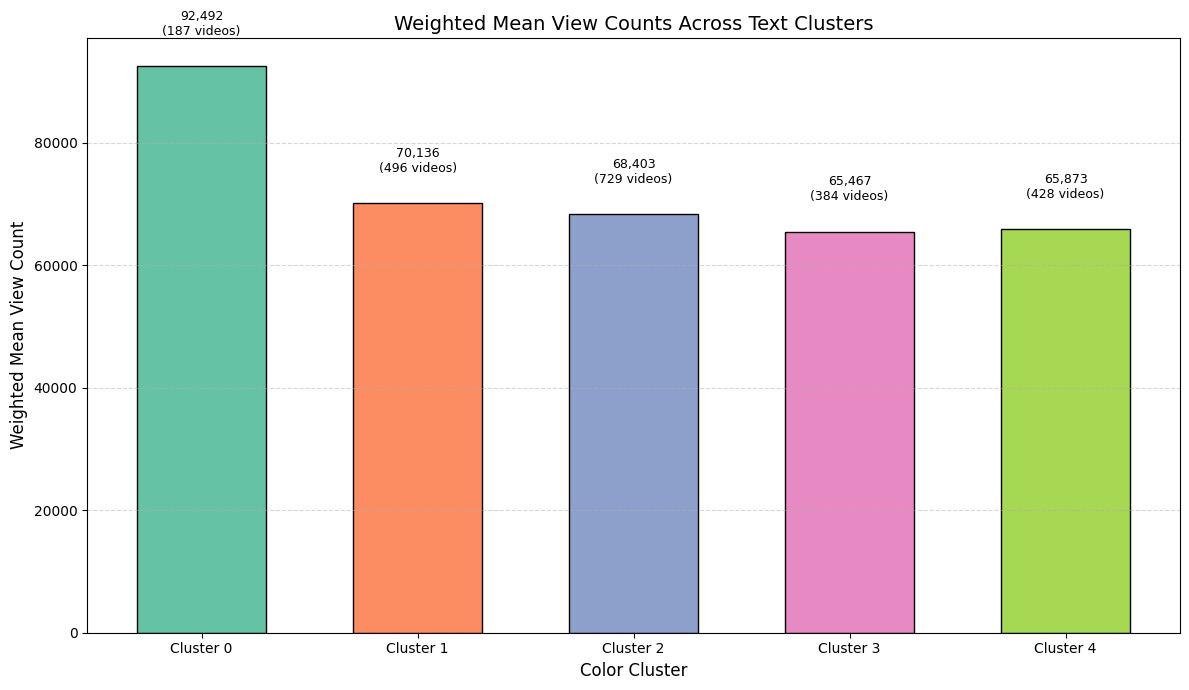

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get list of all clusters
clusters = sorted(clean_data['View Count']['cluster'].unique())

# Calculate weighted means and number of videos per cluster
weighted_means = []
video_counts = []

for cluster in clusters:
    cluster_df = clean_data['View Count'][clean_data['View Count']['cluster'] == cluster]
    views = cluster_df['View Count'].values
    weights = cluster_df['Channel_Weight'].values
    
    if len(views) == 0:
        continue

    # Compute weighted mean
    weighted_mean = np.average(views, weights=weights)
    weighted_means.append(weighted_mean)
    video_counts.append(len(views))

# Create bar-style custom boxplot-like visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Set up positions and width for bars
x_positions = np.arange(len(clusters))
bar_width = 0.6

# Get colors from Seaborn's Set2 palette
colors = sns.color_palette("Set2", len(clusters))

# Plot weighted mean views as bars
bars = ax.bar(x_positions, weighted_means, width=bar_width, color=colors, edgecolor='black')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, video_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (0.05 * max(weighted_means)),
            f'{int(height):,}\n({count} videos)', ha='center', va='bottom', fontsize=9)

# Style the plot
ax.set_title('Weighted Mean View Counts Across Text Clusters', fontsize=14)
ax.set_xlabel('Color Cluster', fontsize=12)
ax.set_ylabel('Weighted Mean View Count', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate with ANOVA result
# try:
#     anova_result_views
#     ax.annotate(f'Weighted ANOVA: F={anova_result_views.statistic:.2f}, p={anova_result_views.pvalue:.4e}',
#                 xy=(0.02, 0.95), xycoords='axes fraction',
#                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# except NameError:
#     ax.annotate('Note: ANOVA result not included', xy=(0.02, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

Like Count

In [ ]:
# Perform ANOVA test on Like Count (with outliers removed)
anova_result_likes = f_oneway(*likes_by_Cluster)

# Print results
print("## Weighted ANOVA Results for Likes ##")
print(f"ANOVA F-statistic: {anova_result_likes.statistic:.4f}")
print(f"p-value: {anova_result_likes.pvalue:.4e}")

# Calculate weighted means for each cluster
weighted_means = []
for i, cluster_data in enumerate(likes_by_Cluster):
    cluster_df = clean_data['Like Count'][clean_data['Like Count']['cluster'] == i]
    weighted_mean = np.average(cluster_data, weights=cluster_df['Channel_Weight'])
    weighted_means.append(weighted_mean)
    print(f"\nCluster {i}:")
    print(f"  Weighted mean likes: {weighted_mean:,.0f}")
    print(f"  Number of videos: {len(cluster_data)}")

# Interpretation
alpha = 0.05
if anova_result_likes.pvalue < alpha:
    print(f"\nRESULT: There are statistically significant differences in Like Count between text Clusters (p < {alpha}).")
    print("This suggests that the weighted like counts differ significantly across clusters.")
else:
    print(f"\nRESULT: No significant differences in Like Count between text Clusters (p > {alpha}).")
    print("This suggests that the weighted like counts are similar across clusters.")

## Weighted ANOVA Results for Likes ##
ANOVA F-statistic: 6.2501
p-value: 5.3345e-05

Cluster 0:
  Weighted mean likes: 3,116
  Number of videos: 190

Cluster 1:
  Weighted mean likes: 2,597
  Number of videos: 502

Cluster 2:
  Weighted mean likes: 2,264
  Number of videos: 746

Cluster 3:
  Weighted mean likes: 1,975
  Number of videos: 388

Cluster 4:
  Weighted mean likes: 1,952
  Number of videos: 430

RESULT: There are statistically significant differences in Like Count between text Clusters (p < 0.05).
This suggests that the weighted like counts differ significantly across clusters.


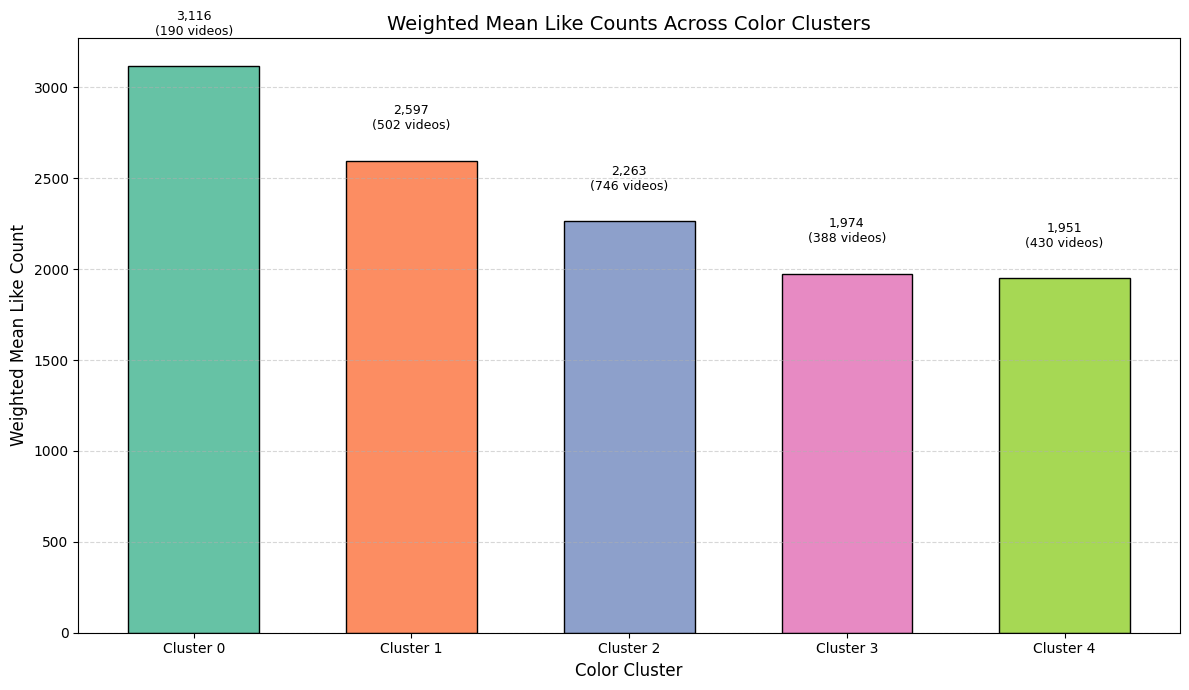

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get list of all clusters
clusters = sorted(clean_data['Like Count']['cluster'].unique())

# Calculate weighted means and number of videos per cluster
weighted_means = []
video_counts = []

for cluster in clusters:
    cluster_df = clean_data['Like Count'][clean_data['Like Count']['cluster'] == cluster]
    likes = cluster_df['Like Count'].values
    weights = cluster_df['Channel_Weight'].values
    
    if len(likes) == 0:
        continue

    # Compute weighted mean
    weighted_mean = np.average(likes, weights=weights)
    weighted_means.append(weighted_mean)
    video_counts.append(len(likes))

# Create bar-style custom boxplot-like visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Set up positions and width for bars
x_positions = np.arange(len(clusters))
bar_width = 0.6

# Get colors from Seaborn's Set2 palette
colors = sns.color_palette("Set2", len(clusters))

# Plot weighted mean likes as bars
bars = ax.bar(x_positions, weighted_means, width=bar_width, color=colors, edgecolor='black')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, video_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (0.05 * max(weighted_means)),
            f'{int(height):,}\n({count} videos)', ha='center', va='bottom', fontsize=9)

# Style the plot
ax.set_title('Weighted Mean Like Counts Across Color Clusters', fontsize=14)
ax.set_xlabel('Color Cluster', fontsize=12)
ax.set_ylabel('Weighted Mean Like Count', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate with ANOVA result
# ax.annotate(f'Weighted ANOVA: F={anova_result_likes.statistic:.2f}, p={anova_result_likes.pvalue:.4e}',
#             xy=(0.02, 0.95), xycoords='axes fraction',
#             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

Comment Count

In [ ]:
# Perform ANOVA test on Comment Count (with outliers removed)
anova_result_comments = f_oneway(*comments_by_Cluster)

# Print results
print("## Weighted ANOVA Results for Comments ##")
print(f"ANOVA F-statistic: {anova_result_comments.statistic:.4f}")
print(f"p-value: {anova_result_comments.pvalue:.4e}")

# Calculate weighted means for each cluster
weighted_means = []
for i, cluster_data in enumerate(comments_by_Cluster):
    cluster_df = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == i]
    weighted_mean = np.average(cluster_data, weights=cluster_df['Channel_Weight'])
    weighted_means.append(weighted_mean)
    print(f"\nCluster {i}:")
    print(f"  Weighted mean comments: {weighted_mean:,.0f}")
    print(f"  Number of videos: {len(cluster_data)}")

# Interpretation
alpha = 0.05
if anova_result_comments.pvalue < alpha:
    print(f"\nRESULT: There are statistically significant differences in Comment Count between text Clusters (p < {alpha}).")
    print("This suggests that the weighted comment counts differ significantly across clusters.")
else:
    print(f"\nRESULT: No significant differences in Comment Count between text Clusters (p > {alpha}).")
    print("This suggests that the weighted comment counts are similar across clusters.")

## Weighted ANOVA Results for Comments ##
ANOVA F-statistic: 5.0078
p-value: 5.1072e-04

Cluster 0:
  Weighted mean comments: 274
  Number of videos: 193

Cluster 1:
  Weighted mean comments: 222
  Number of videos: 493

Cluster 2:
  Weighted mean comments: 201
  Number of videos: 733

Cluster 3:
  Weighted mean comments: 197
  Number of videos: 381

Cluster 4:
  Weighted mean comments: 189
  Number of videos: 432

RESULT: There are statistically significant differences in Comment Count between text Clusters (p < 0.05).
This suggests that the weighted comment counts differ significantly across clusters.


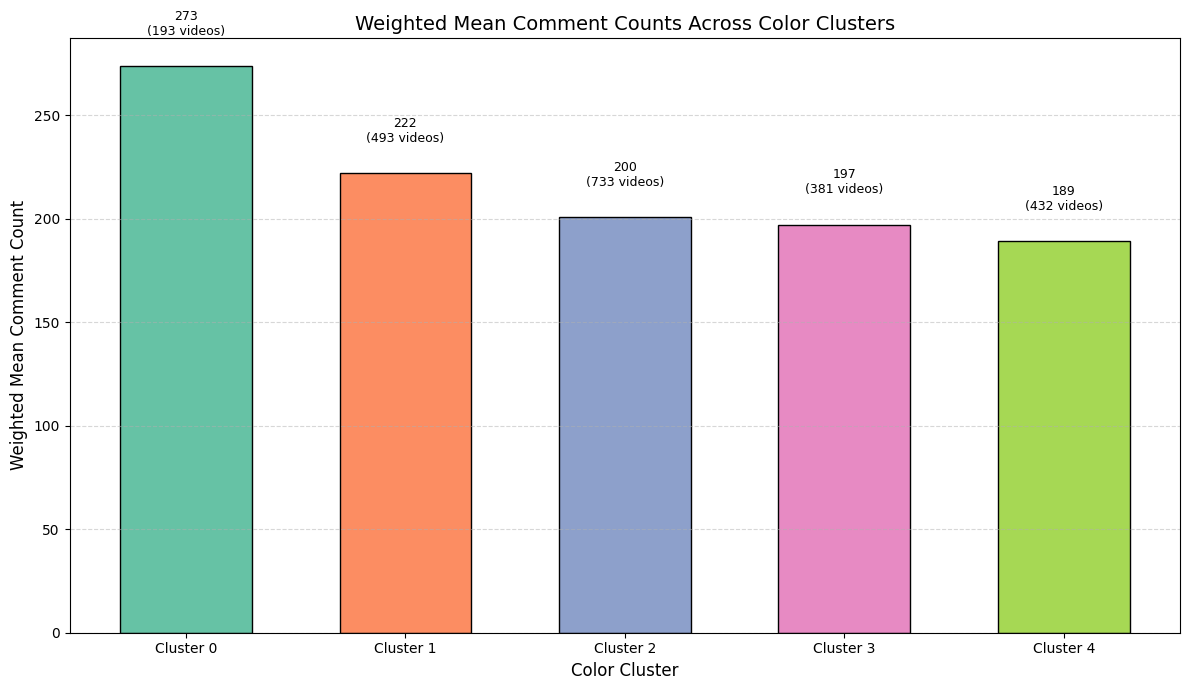

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get list of all clusters
clusters = sorted(clean_data['Comment Count']['cluster'].unique())

# Calculate weighted means and number of videos per cluster
weighted_means = []
video_counts = []

for cluster in clusters:
    cluster_df = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == cluster]
    comments = cluster_df['Comment Count'].values
    weights = cluster_df['Channel_Weight'].values
    
    if len(comments) == 0:
        continue

    # Compute weighted mean
    weighted_mean = np.average(comments, weights=weights)
    weighted_means.append(weighted_mean)
    video_counts.append(len(comments))

# Create bar-style custom boxplot-like visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Set up positions and width for bars
x_positions = np.arange(len(clusters))
bar_width = 0.6

# Get colors from Seaborn's Set2 palette
colors = sns.color_palette("Set2", len(clusters))

# Plot weighted mean comments as bars
bars = ax.bar(x_positions, weighted_means, width=bar_width, color=colors, edgecolor='black')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, video_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (0.05 * max(weighted_means)),
            f'{int(height):,}\n({count} videos)', ha='center', va='bottom', fontsize=9)

# Style the plot
ax.set_title('Weighted Mean Comment Counts Across Color Clusters', fontsize=14)
ax.set_xlabel('Color Cluster', fontsize=12)
ax.set_ylabel('Weighted Mean Comment Count', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate with ANOVA result
# try:
#     anova_result_comments
#     ax.annotate(f'Weighted ANOVA: F={anova_result_comments.statistic:.2f}, p={anova_result_comments.pvalue:.4e}',
#                 xy=(0.02, 0.95), xycoords='axes fraction',
#                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# except NameError:
#     ax.annotate('Note: ANOVA result not included', xy=(0.02, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

Using the Post-hoc Bonferroni correction to identify which specific clusters differ from each other.

View


In [ ]:
from scipy.stats import ttest_ind
from itertools import combinations

# Load clean_data['View Count'] (already outlier-removed)
clean_view_data = clean_data['View Count'].copy()

# Define significance level
alpha = 0.05
n_clusters = len(clean_view_data['cluster'].unique())
num_comparisons = n_clusters * (n_clusters - 1) // 2  # Total pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted threshold

print(f"## Weighted Post-Hoc Comparison: View Count ##")
print(f"Number of clusters: {n_clusters}")
print(f"Total pairwise comparisons: {num_comparisons}")
print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.6f}")
print(f"{'-'*60}")

# Store results
post_hoc_results = []

# Get all cluster pairs
clusters = sorted(clean_view_data['cluster'].unique())

for cluster_i, cluster_j in combinations(clusters, 2):
    # Extract data for each cluster
    df_i = clean_view_data[clean_view_data['cluster'] == cluster_i]
    df_j = clean_view_data[clean_view_data['cluster'] == cluster_j]
    
    if len(df_i) == 0 or len(df_j) == 0:
        continue

    # Compute weighted means
    mean_i = np.average(df_i['View Count'], weights=df_i['Channel_Weight'])
    mean_j = np.average(df_j['View Count'], weights=df_j['Channel_Weight'])
    
    # Compute difference
    diff = mean_i - mean_j

    # Perform unweighted t-test (Welch's t-test) — best available proxy
    t_stat, p_value = ttest_ind(df_i['View Count'], df_j['View Count'], equal_var=False)

    # Apply Bonferroni correction
    significant = p_value < bonferroni_alpha

    post_hoc_results.append({
        'Cluster_i': cluster_i,
        'Cluster_j': cluster_j,
        'Mean_i': round(mean_i, 2),
        'Mean_j': round(mean_j, 2),
        'Diff': round(diff, 2),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'p_adj_threshold': round(bonferroni_alpha, 6),
        'significant': significant
    })

# Convert to DataFrame
results_df = pd.DataFrame(post_hoc_results)

# Sort by absolute difference (largest first)
results_df = results_df.sort_values('Diff', key=abs, ascending=False).reset_index(drop=True)

# Print weighted mean view counts for reference
print("\nWeighted Mean View Counts by Cluster:")
for cluster in clusters:
    cluster_df = clean_view_data[clean_view_data['cluster'] == cluster]
    weighted_mean = np.average(cluster_df['View Count'], weights=cluster_df['Channel_Weight'])
    print(f"  Cluster {cluster}: {weighted_mean:,.0f} views")

# Print all 36 comparisons
print(f"\n{'='*80}")
print("ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)")
print(f"{'='*80}")
print(f"{'Cluster Pair':<12} {'Mean_i':>12} {'Mean_j':>12} {'Diff':>12} {'p-value':>12} {'Significant':>12}")
print(f"{'-'*80}")
for _, row in results_df.iterrows():
    sig_str = "Yes" if row['significant'] else "No"
    print(f"({row['Cluster_i']} vs {row['Cluster_j']}): "
          f"{row['Mean_i']:>12,.0f} "
          f"{row['Mean_j']:>12,.0f} "
          f"{row['Diff']:>12,.0f} "
          f"{row['p_value']:>12.6f} "
          f"{sig_str:>12}")

# Summary of significant results
significant_count = results_df['significant'].sum()
print(f"\nSummary:")
print(f"Total comparisons: {len(results_df)}")
print(f"Significant differences (p < {bonferroni_alpha:.6f}): {significant_count}")
if significant_count == 0:
    print("No pairwise differences reached statistical significance after Bonferroni correction.")
else:
    print(f"Significant pairs: ")
    sig_pairs = results_df[results_df['significant']][['Cluster_i', 'Cluster_j', 'Diff', 'p_value']]
    for _, row in sig_pairs.iterrows():
        print(f"  Cluster {row['Cluster_i']} vs {row['Cluster_j']}: Δ = {row['Diff']:+,.0f}, p = {row['p_value']:.2e}")

## Weighted Post-Hoc Comparison: View Count ##
Number of clusters: 5
Total pairwise comparisons: 10
Bonferroni-corrected alpha: 0.005000
------------------------------------------------------------

Weighted Mean View Counts by Cluster:
  Cluster 0: 92,492 views
  Cluster 1: 70,137 views
  Cluster 2: 68,404 views
  Cluster 3: 65,468 views
  Cluster 4: 65,873 views

ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)
Cluster Pair       Mean_i       Mean_j         Diff      p-value  Significant
--------------------------------------------------------------------------------
(0 vs 3):       92,492       65,468       27,025     0.007100           No
(0 vs 4):       92,492       65,873       26,619     0.000890          Yes
(0 vs 2):       92,492       68,404       24,089     0.025213           No
(0 vs 1):       92,492       70,137       22,356     0.103303           No
(1 vs 3):       70,137       65,468        4,669     0.110754           No
(1 vs 4):       70,137       65,8

like


In [ ]:
# Load clean_data['Like Count'] (already outlier-removed)
clean_like_data = clean_data['Like Count'].copy()

# Define significance level
alpha = 0.05
n_clusters = len(clean_like_data['cluster'].unique())
num_comparisons = n_clusters * (n_clusters - 1) // 2  # Total pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted threshold

print(f"## Weighted Post-Hoc Comparison: Like Count ##")
print(f"Number of clusters: {n_clusters}")
print(f"Total pairwise comparisons: {num_comparisons}")
print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.6f}")
print(f"{'-'*60}")

# Store results
post_hoc_results = []

# Get all cluster pairs
clusters = sorted(clean_like_data['cluster'].unique())

for cluster_i, cluster_j in combinations(clusters, 2):
    # Extract data for each cluster
    df_i = clean_like_data[clean_like_data['cluster'] == cluster_i]
    df_j = clean_like_data[clean_like_data['cluster'] == cluster_j]
    
    if len(df_i) == 0 or len(df_j) == 0:
        continue

    # Compute weighted means
    mean_i = np.average(df_i['Like Count'], weights=df_i['Channel_Weight'])
    mean_j = np.average(df_j['Like Count'], weights=df_j['Channel_Weight'])
    
    # Compute difference
    diff = mean_i - mean_j

    # Perform unweighted t-test (Welch's t-test) — best available proxy
    t_stat, p_value = ttest_ind(df_i['Like Count'], df_j['Like Count'], equal_var=False)

    # Apply Bonferroni correction: mark as significant if p < adjusted alpha
    significant = p_value < bonferroni_alpha

    post_hoc_results.append({
        'Cluster_i': cluster_i,
        'Cluster_j': cluster_j,
        'Mean_i': round(mean_i, 2),
        'Mean_j': round(mean_j, 2),
        'Diff': round(diff, 2),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'p_adj_threshold': round(bonferroni_alpha, 6),
        'significant': significant
    })

# Convert to DataFrame
results_df = pd.DataFrame(post_hoc_results)

# Sort by absolute difference (largest first)
results_df = results_df.sort_values('Diff', key=abs, ascending=False).reset_index(drop=True)

# Print weighted mean like counts for reference
print("\nWeighted Mean Like Counts by Cluster:")
for cluster in clusters:
    cluster_df = clean_like_data[clean_like_data['cluster'] == cluster]
    weighted_mean = np.average(cluster_df['Like Count'], weights=cluster_df['Channel_Weight'])
    print(f"  Cluster {cluster}: {weighted_mean:,.0f} likes")

# Print all 36 comparisons
print(f"\n{'='*80}")
print("ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)")
print(f"{'='*80}")
print(f"{'Cluster Pair':<12} {'Mean_i':>10} {'Mean_j':>10} {'Diff':>10} {'p-value':>12} {'Significant':>12}")
print(f"{'-'*80}")
for _, row in results_df.iterrows():
    sig_str = "Yes" if row['significant'] else "No"
    print(f"({row['Cluster_i']} vs {row['Cluster_j']}): "
          f"{row['Mean_i']:>10.0f} "
          f"{row['Mean_j']:>10.0f} "
          f"{row['Diff']:>10.0f} "
          f"{row['p_value']:>12.6f} "
          f"{sig_str:>12}")

# Summary of significant results
significant_count = results_df['significant'].sum()
print(f"\nSummary:")
print(f"Total comparisons: {len(results_df)}")
print(f"Significant differences (p < {bonferroni_alpha:.6f}): {significant_count}")
if significant_count == 0:
    print("No pairwise differences reached statistical significance after Bonferroni correction.")
else:
    print(f"Significant pairs: ")
    sig_pairs = results_df[results_df['significant']][['Cluster_i', 'Cluster_j', 'Diff', 'p_value']]
    for _, row in sig_pairs.iterrows():
        print(f"  Cluster {row['Cluster_i']} vs {row['Cluster_j']}: Δ = {row['Diff']:+.0f}, p = {row['p_value']:.2e}")

## Weighted Post-Hoc Comparison: Like Count ##
Number of clusters: 5
Total pairwise comparisons: 10
Bonferroni-corrected alpha: 0.005000
------------------------------------------------------------

Weighted Mean Like Counts by Cluster:
  Cluster 0: 3,116 likes
  Cluster 1: 2,597 likes
  Cluster 2: 2,264 likes
  Cluster 3: 1,975 likes
  Cluster 4: 1,952 likes

ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)
Cluster Pair     Mean_i     Mean_j       Diff      p-value  Significant
--------------------------------------------------------------------------------
(0 vs 4):       3116       1952       1165     0.000085          Yes
(0 vs 3):       3116       1975       1141     0.006909           No
(0 vs 2):       3116       2264        852     0.044850           No
(1 vs 4):       2597       1952        646     0.000164          Yes
(1 vs 3):       2597       1975        623     0.060176           No
(0 vs 1):       3116       2597        519     0.148562           No
(1 vs

comment

In [ ]:
# Load clean_data['Comment Count'] (already outlier-removed)
clean_comment_data = clean_data['Comment Count'].copy()

# Define significance level
alpha = 0.05
n_clusters = len(clean_comment_data['cluster'].unique())
num_comparisons = n_clusters * (n_clusters - 1) // 2  # Total pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted threshold

print(f"## Weighted Post-Hoc Comparison: Comment Count ##")
print(f"Number of clusters: {n_clusters}")
print(f"Total pairwise comparisons: {num_comparisons}")
print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.6f}")
print(f"{'-'*60}")

# Store results
post_hoc_results = []

# Get all cluster pairs
clusters = sorted(clean_comment_data['cluster'].unique())

for cluster_i, cluster_j in combinations(clusters, 2):
    # Extract data for each cluster
    df_i = clean_comment_data[clean_comment_data['cluster'] == cluster_i]
    df_j = clean_comment_data[clean_comment_data['cluster'] == cluster_j]
    
    if len(df_i) == 0 or len(df_j) == 0:
        continue

    # Compute weighted means
    mean_i = np.average(df_i['Comment Count'], weights=df_i['Channel_Weight'])
    mean_j = np.average(df_j['Comment Count'], weights=df_j['Channel_Weight'])
    
    # Compute difference
    diff = mean_i - mean_j

    # Perform unweighted t-test (Welch's t-test)
    t_stat, p_value = ttest_ind(df_i['Comment Count'], df_j['Comment Count'], equal_var=False)

    # Apply Bonferroni correction
    significant = p_value < bonferroni_alpha

    post_hoc_results.append({
        'Cluster_i': cluster_i,
        'Cluster_j': cluster_j,
        'Mean_i': round(mean_i, 2),
        'Mean_j': round(mean_j, 2),
        'Diff': round(diff, 2),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'p_adj_threshold': round(bonferroni_alpha, 6),
        'significant': significant
    })

# Convert to DataFrame
results_df = pd.DataFrame(post_hoc_results)

# Sort by absolute difference (largest first)
results_df = results_df.sort_values('Diff', key=abs, ascending=False).reset_index(drop=True)

# Print weighted mean comment counts for reference
print("\nWeighted Mean Comment Counts by Cluster:")
for cluster in clusters:
    cluster_df = clean_comment_data[clean_comment_data['cluster'] == cluster]
    weighted_mean = np.average(cluster_df['Comment Count'], weights=cluster_df['Channel_Weight'])
    print(f"  Cluster {cluster}: {weighted_mean:,.0f} comments")

# Print all 36 comparisons
print(f"\n{'='*80}")
print("ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)")
print(f"{'='*80}")
print(f"{'Cluster Pair':<12} {'Mean_i':>12} {'Mean_j':>12} {'Diff':>12} {'p-value':>12} {'Significant':>12}")
print(f"{'-'*80}")
for _, row in results_df.iterrows():
    sig_str = "Yes" if row['significant'] else "No"
    print(f"({row['Cluster_i']} vs {row['Cluster_j']}): "
          f"{row['Mean_i']:>12,.0f} "
          f"{row['Mean_j']:>12,.0f} "
          f"{row['Diff']:>12,.0f} "
          f"{row['p_value']:>12.6f} "
          f"{sig_str:>12}")

# Summary of significant results
significant_count = results_df['significant'].sum()
print(f"\nSummary:")
print(f"Total comparisons: {len(results_df)}")
print(f"Significant differences (p < {bonferroni_alpha:.6f}): {significant_count}")
if significant_count == 0:
    print("No pairwise differences reached statistical significance after Bonferroni correction.")
else:
    print(f"Significant pairs: ")
    sig_pairs = results_df[results_df['significant']][['Cluster_i', 'Cluster_j', 'Diff', 'p_value']]
    for _, row in sig_pairs.iterrows():
        print(f"  Cluster {row['Cluster_i']} vs {row['Cluster_j']}: Δ = {row['Diff']:+,.0f}, p = {row['p_value']:.2e}")

## Weighted Post-Hoc Comparison: Comment Count ##
Number of clusters: 5
Total pairwise comparisons: 10
Bonferroni-corrected alpha: 0.005000
------------------------------------------------------------

Weighted Mean Comment Counts by Cluster:
  Cluster 0: 274 comments
  Cluster 1: 222 comments
  Cluster 2: 201 comments
  Cluster 3: 197 comments
  Cluster 4: 189 comments

ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)
Cluster Pair       Mean_i       Mean_j         Diff      p-value  Significant
--------------------------------------------------------------------------------
(0 vs 4):          274          189           85     0.000078          Yes
(0 vs 3):          274          197           76     0.002468          Yes
(0 vs 2):          274          201           73     0.004018          Yes
(0 vs 1):          274          222           52     0.009078           No
(1 vs 4):          222          189           33     0.034410           No
(1 vs 3):          222     

## ANOVA Correlation (No Weight)

In [ ]:
## ANOVA Analysis for Text Clusters

# Define the metrics we'll analyze
metric_columns = ['View Count', 'Like Count', 'Comment Count']
print(f"Analyzing metrics: {', '.join(metric_columns)}")

# Set significance level
alpha = 0.05

Analyzing metrics: View Count, Like Count, Comment Count


In [ ]:
# Function to identify and remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create masks for outliers and non-outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Return dataframes with and without outliers
    return df[~outlier_mask], df[outlier_mask]

# Create dictionaries to store clean data and outliers
clean_data = {}
outliers = {}

View Count

Outlier Analysis - Views:
Original video count: 2568
After outlier removal: 2224
Videos removed: 344 (13.4%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\2372541207.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\2372541207.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], ax=ax2, palette='Set2')


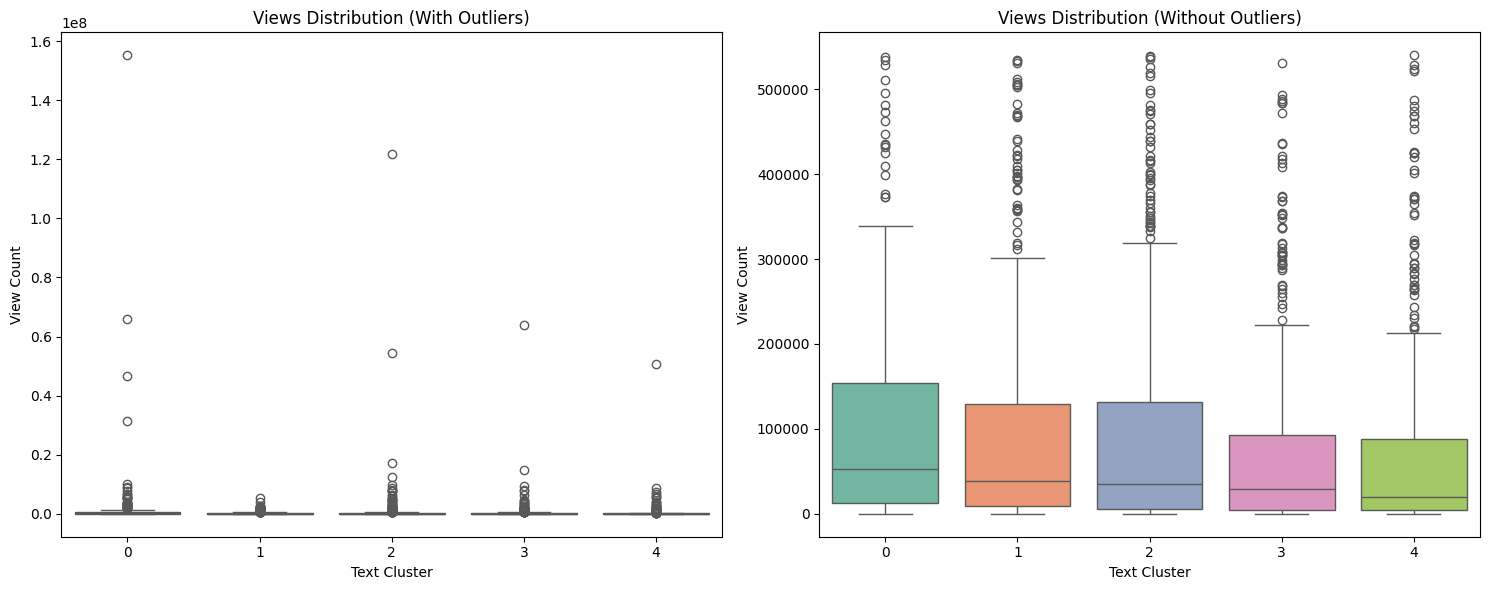

In [ ]:
# Remove outliers for View Count
clean_data['View Count'], outliers['View Count'] = remove_outliers(merged_data, 'View Count')

print("Outlier Analysis - Views:")
print(f"Original video count: {merged_data['VideoID'].nunique()}")
print(f"After outlier removal: {clean_data['View Count']['VideoID'].nunique()}")
print(f"Videos removed: {merged_data['VideoID'].nunique() - clean_data['View Count']['VideoID'].nunique()} "
      f"({(merged_data['VideoID'].nunique() - clean_data['View Count']['VideoID'].nunique()) / merged_data['VideoID'].nunique() * 100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='View Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Views Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('View Count')

# After outlier removal
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], ax=ax2, palette='Set2')
ax2.set_title('Views Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('View Count')

plt.tight_layout()
plt.show()


Number of videos per cluster after outlier removal:
cluster
0    187
1    496
2    729
3    384
4    428
Name: VideoID, dtype: int64


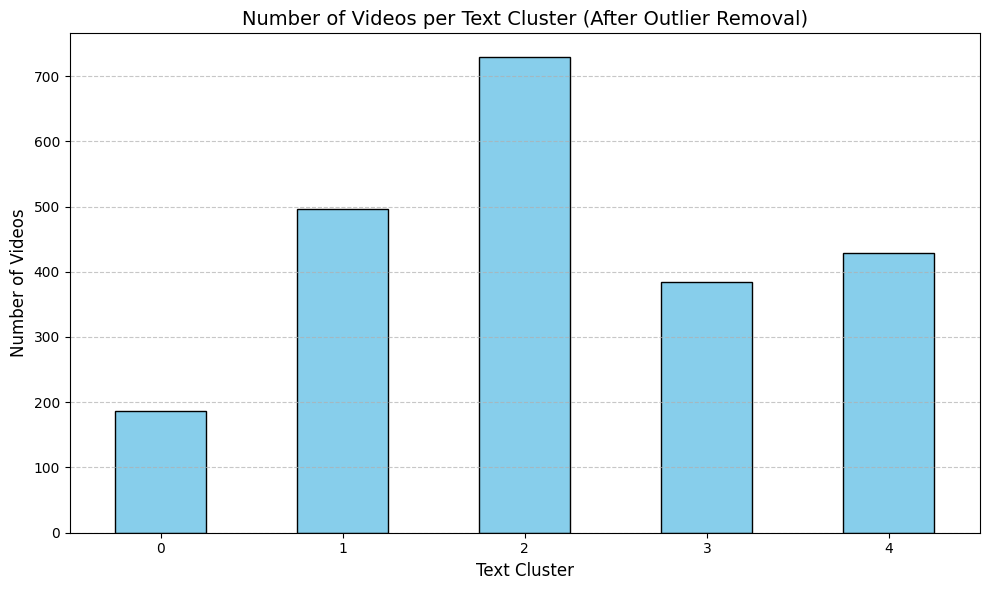

In [ ]:
# Count number of videos per cluster after outlier removal
videos_per_cluster = clean_data['View Count'].groupby('cluster')['VideoID'].nunique()

print("\nNumber of videos per cluster after outlier removal:")
print(videos_per_cluster)

# Optional: Plot a bar chart to visualize the number of videos per cluster
plt.figure(figsize=(10, 6))
videos_per_cluster.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Videos per Text Cluster (After Outlier Removal)', fontsize=14)
plt.xlabel('Text Cluster', fontsize=12)
plt.ylabel('Number of Videos', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Like Count


Outlier Analysis - Likes:
Original data points: 2568
After outlier removal: 2256
Outliers removed: 312 (12.1%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\2246965847.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\2246965847.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], ax=ax2, palette='Set2')


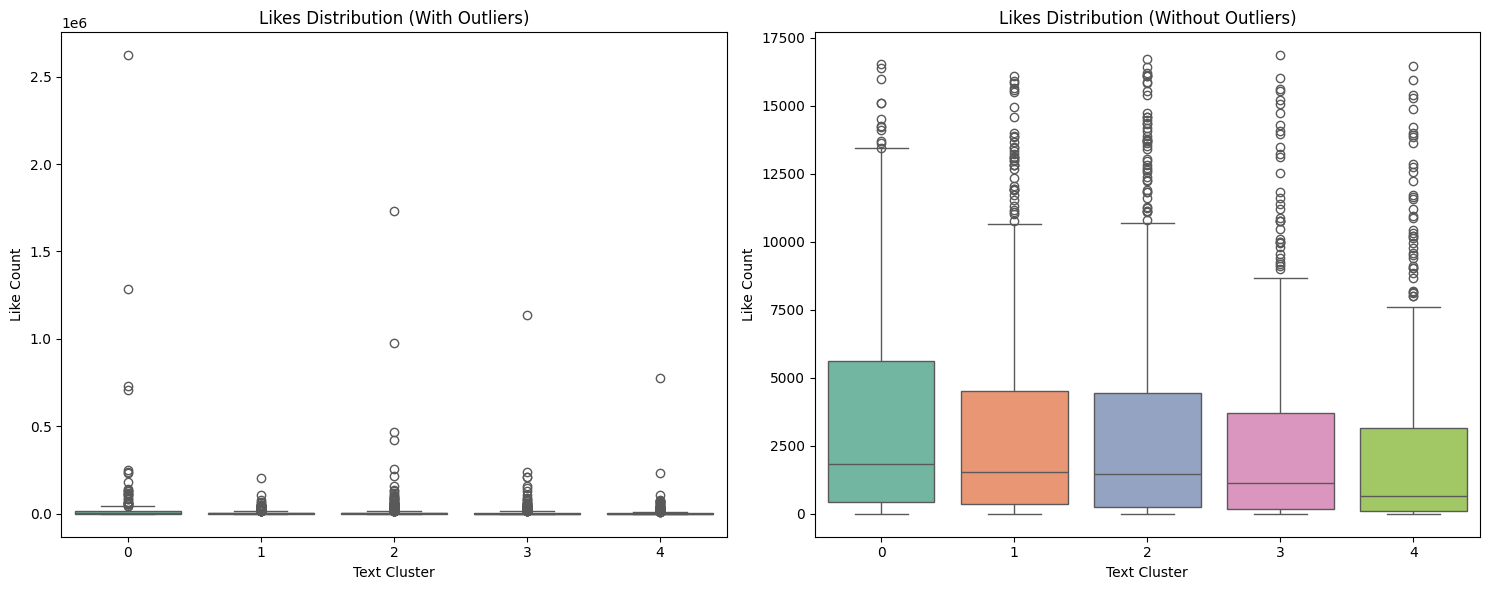

In [ ]:
# Remove outliers for Like Count
clean_data['Like Count'], outliers['Like Count'] = remove_outliers(merged_data, 'Like Count')

print("Outlier Analysis - Likes:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['Like Count'])}")
print(f"Outliers removed: {len(outliers['Like Count'])} ({len(outliers['Like Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='Like Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Likes Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('Like Count')

# After outlier removal
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], ax=ax2, palette='Set2')
ax2.set_title('Likes Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('Like Count')

plt.tight_layout()
plt.show()

Commetn Count

Outlier Analysis - Comments:
Original data points: 2568
After outlier removal: 2232
Outliers removed: 336 (13.1%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\2573769111.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\2573769111.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], ax=ax2, palette='Set2')


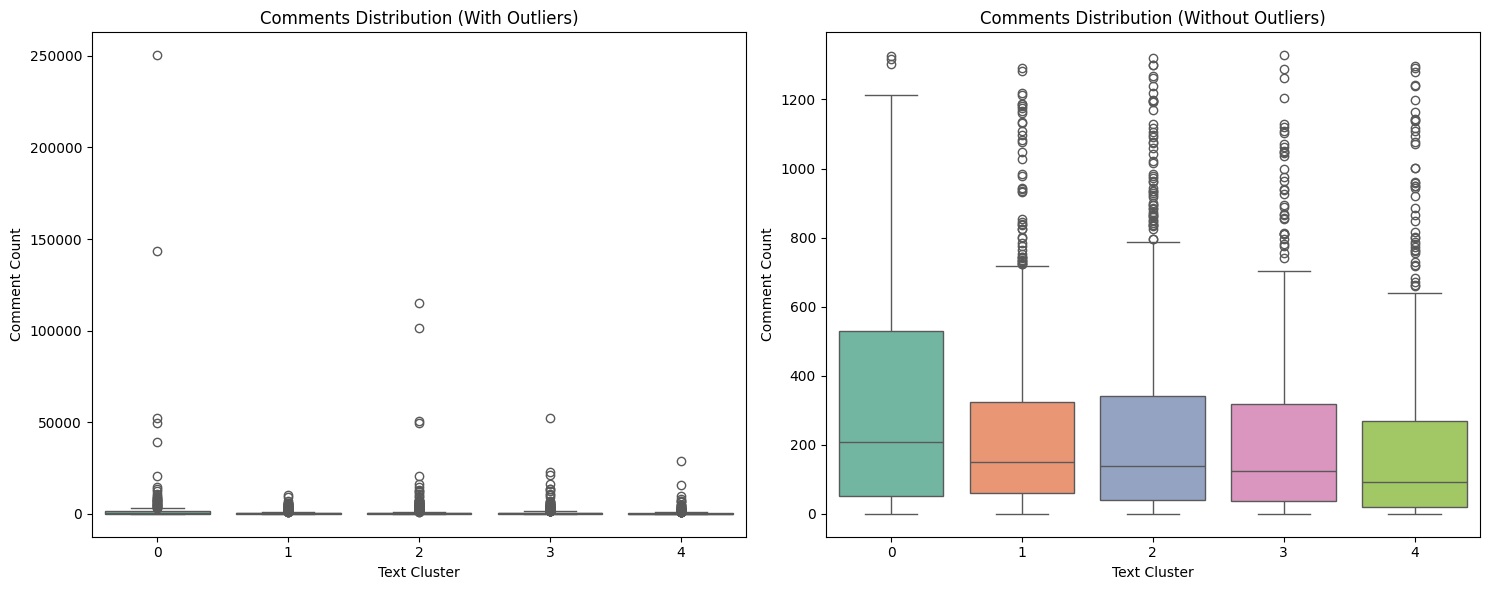

In [ ]:
# Remove outliers for Comment Count
clean_data['Comment Count'], outliers['Comment Count'] = remove_outliers(merged_data, 'Comment Count')

print("Outlier Analysis - Comments:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['Comment Count'])}")
print(f"Outliers removed: {len(outliers['Comment Count'])} ({len(outliers['Comment Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='Comment Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Comments Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('Comment Count')

# After outlier removal
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], ax=ax2, palette='Set2')
ax2.set_title('Comments Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('Comment Count')

plt.tight_layout()
plt.show()

See all the total of videos per cluster

In [ ]:
# Group cleaned data by cluster for ANOVA analysis
views_by_cluster = []
likes_by_cluster = []
comments_by_cluster = []

# Create clusters for ANOVA
for cluster_id in sorted(merged_data['cluster'].unique()):
    # Get data for this cluster with outliers removed
    cluster_views = clean_data['View Count'][clean_data['View Count']['cluster'] == cluster_id]['View Count'].values
    views_by_cluster.append(cluster_views)
    
    cluster_likes = clean_data['Like Count'][clean_data['Like Count']['cluster'] == cluster_id]['Like Count'].values
    likes_by_cluster.append(cluster_likes)
    
    cluster_comments = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == cluster_id]['Comment Count'].values
    comments_by_cluster.append(cluster_comments)
    
    # Print some info about the data we're using
    print(f"Cluster {cluster_id} (after outlier removal):")
    print(f"  Views: {len(cluster_views)} videos")
    print(f"  Likes: {len(cluster_likes)} videos")
    print(f"  Comments: {len(cluster_comments)} videos")

Cluster 0 (after outlier removal):
  Views: 187 videos
  Likes: 190 videos
  Comments: 193 videos
Cluster 1 (after outlier removal):
  Views: 496 videos
  Likes: 502 videos
  Comments: 493 videos
Cluster 2 (after outlier removal):
  Views: 729 videos
  Likes: 746 videos
  Comments: 733 videos
Cluster 3 (after outlier removal):
  Views: 384 videos
  Likes: 388 videos
  Comments: 381 videos
Cluster 4 (after outlier removal):
  Views: 428 videos
  Likes: 430 videos
  Comments: 432 videos


view count anova

In [ ]:
# Perform ANOVA test on Views
anova_views = f_oneway(*views_by_cluster)

print("## ANOVA Results for Views ##")
print(f"F-statistic: {anova_views.statistic:.4f}")
print(f"p-value: {anova_views.pvalue:.4e}")

if anova_views.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Views across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Views across text clusters (p > {alpha}).")

## ANOVA Results for Views ##
F-statistic: 4.0791
p-value: 2.6845e-03
RESULT: There are statistically significant differences in Views across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\4203132139.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], palette='Set2')


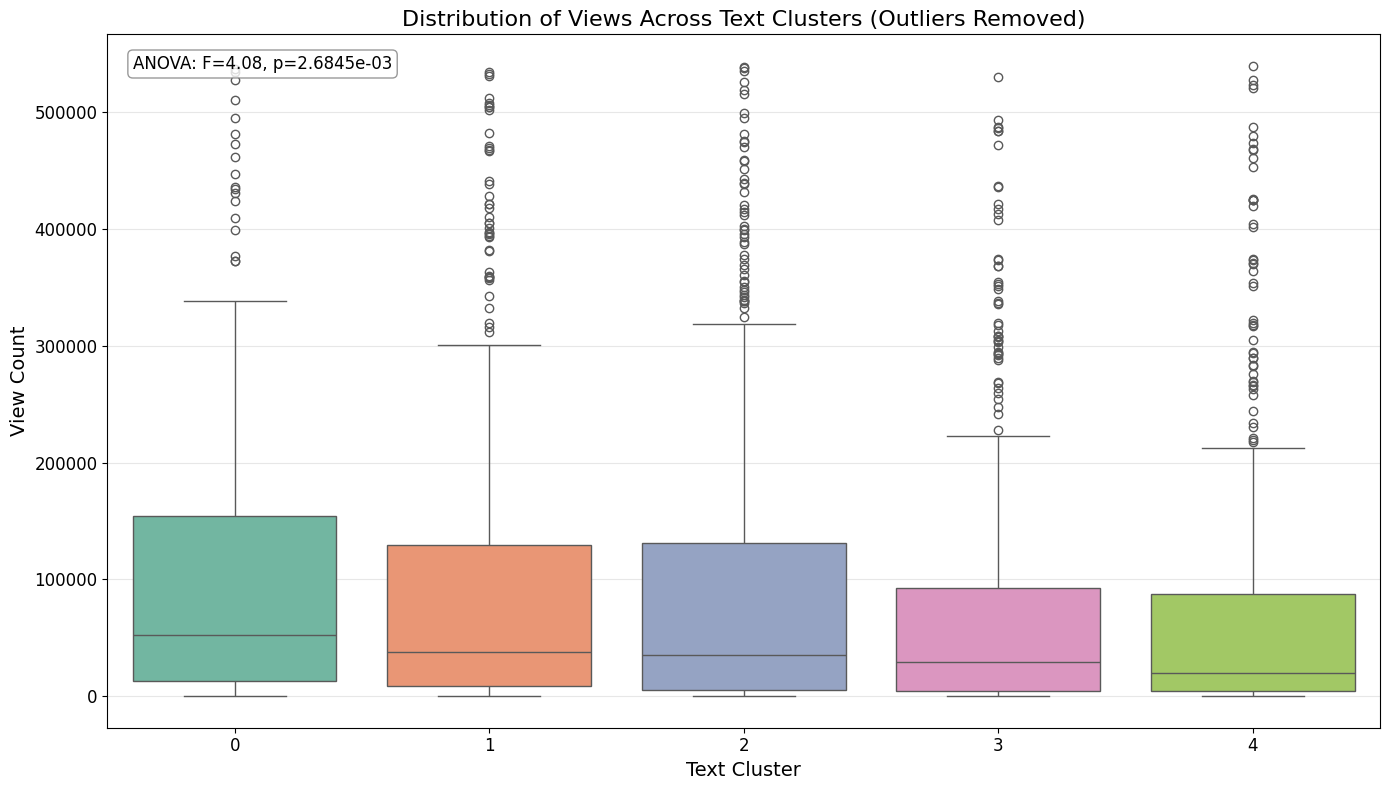

In [ ]:
# Create boxplot for Views distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Views Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('View Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_views.statistic:.2f}, p={anova_views.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

Like count anova

In [ ]:
# Perform ANOVA test on Likes
anova_likes = f_oneway(*likes_by_cluster)

print("## ANOVA Results for Likes ##")
print(f"F-statistic: {anova_likes.statistic:.4f}")
print(f"p-value: {anova_likes.pvalue:.4e}")

if anova_likes.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Likes across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Likes across text clusters (p > {alpha}).")

## ANOVA Results for Likes ##
F-statistic: 6.2501
p-value: 5.3345e-05
RESULT: There are statistically significant differences in Likes across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\1990300238.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')


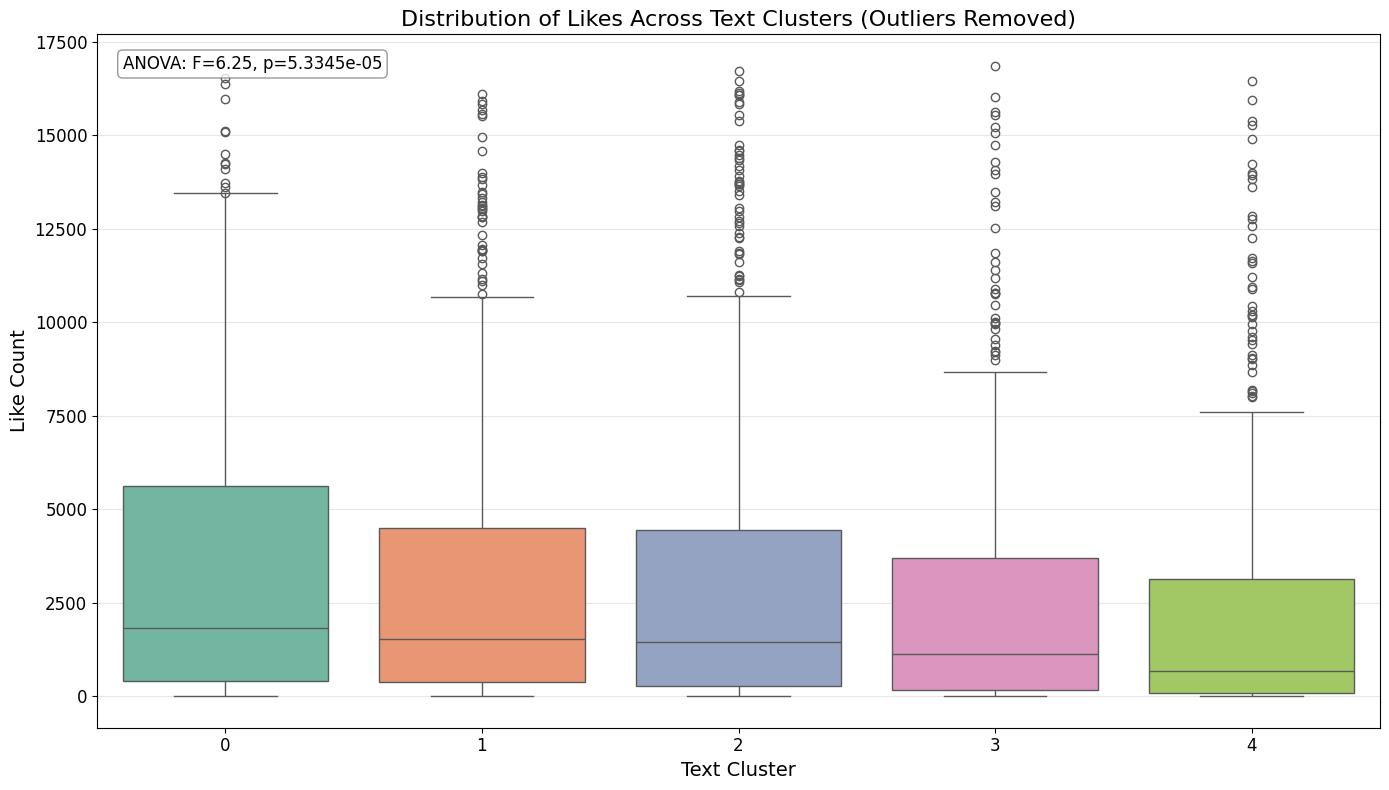

In [ ]:
# Create boxplot for Likes distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Likes Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('Like Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_likes.statistic:.2f}, p={anova_likes.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

comment count anova

In [ ]:
# Perform ANOVA test on Comments
anova_comments = f_oneway(*comments_by_cluster)

print("## ANOVA Results for Comments ##")
print(f"F-statistic: {anova_comments.statistic:.4f}")
print(f"p-value: {anova_comments.pvalue:.4e}")

if anova_comments.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Comments across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Comments across text clusters (p > {alpha}).")

## ANOVA Results for Comments ##
F-statistic: 5.0078
p-value: 5.1072e-04
RESULT: There are statistically significant differences in Comments across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_22108\1842981975.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')


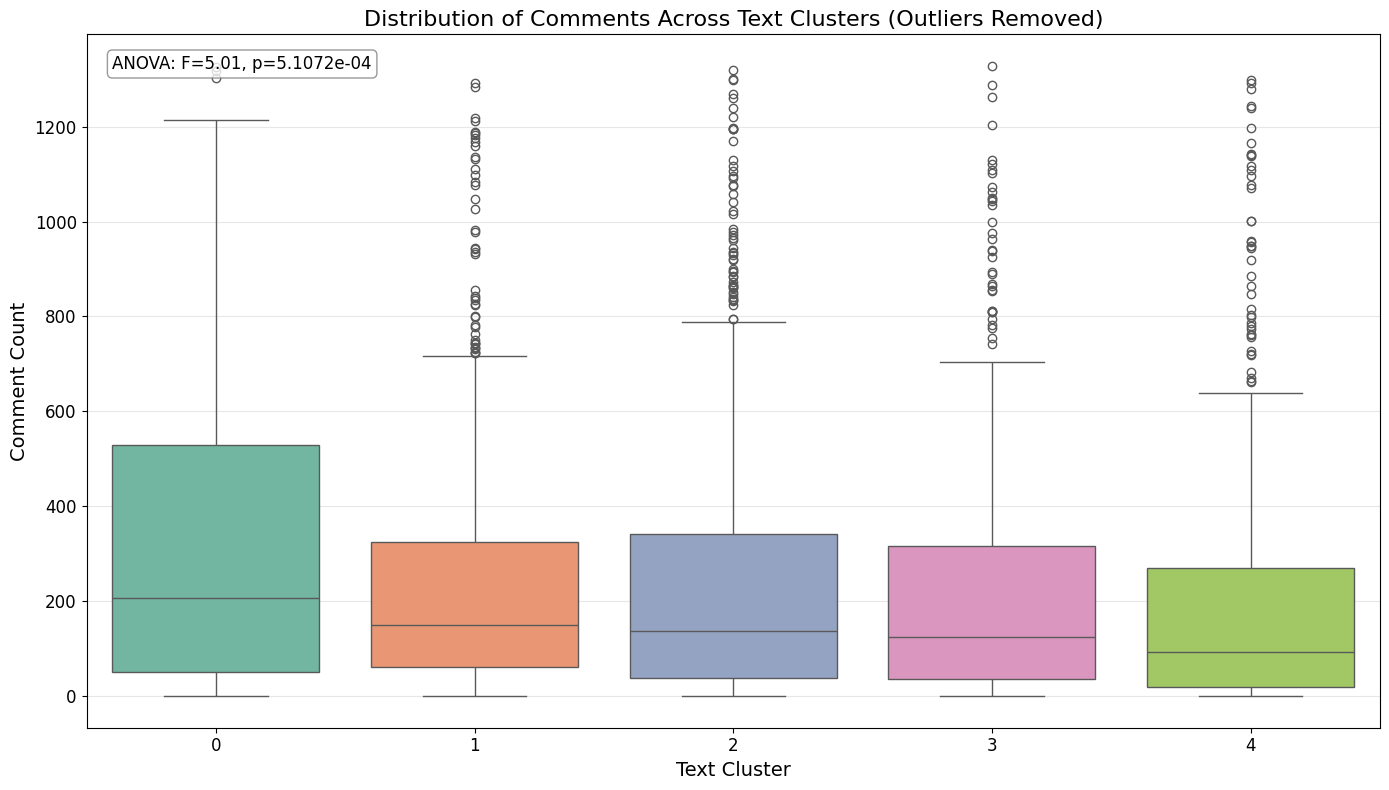

In [ ]:
# Create boxplot for Comments distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Comments Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('Comment Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_comments.statistic:.2f}, p={anova_comments.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

Check what is the top 5 channel with the most video with each cluster